# Script to analyse Local Group analogues to determine the mass of the LG and its constituents.

### (c) Till Sawala and Meri Teeriaho (2022). Address for this notebook: https://github.com/TillSawala/LG_mass

#### Please feel free to use any parts in your own work. If you find any parts of this work useful, we would appreciate a citation to our paper: Sawala, Teeriaho & Johansson (2022).
#### Please note that the script needs to be run in the correct order, and that some parts of this script take a long time to run. Intermediate results are saved in files. To avoid repeating the analysis in subsequent runs, set the following parameters after the first run: `compute_timing = False`, `compute_timing_MC = False`, `training = False`, `bootstrapping_training = False`. 

#### The Uchuu halo catalogue data (Ishiyama T., et al., 2021, MNRAS, 506, 4210) on which our results are based can be downloaded at: http://skun.iaa.es/SUsimulations/UchuuDR1/Uchuu/RockstarExtendedM200c1e11/ Our processed catalogue of LG pairs selected from the Uchuu simulation, on which this notebook is based, can be downloaded at: https://drive.google.com/drive/folders/1TCpq9qT526abpXBAPxvZ6IfhAUnZigEv?usp=sharing . That folder also includes files with intermediate results, making it possible to run the notebook with all of the above parameters set to `False`. Of course, any works based on this data should also cite Ishiyama et al. (2021).

### Please contact till.sawala@helsinki.fi for any questions!

# Table of contents <a id='Contents'></a>

## Preliminaries

### [Imports](#Imports), [setting parameters](#Parameters), definitions of [custom Functions](#Functions)
### [Load files and define basic subsets](#LoadFiles)
### [Define subsets and weights for the data](#DefineSubsets)

### Print the [$v_t$ posteriors](#vtPosteriors)

## Pre-Calculations, Model Training

### [Compute the Timing Argument masses](#Timing) for objects in the simulations, and [for MC samples of the observations](#TimingMC)

### Gaussian Process Regression: either [train the GPR model](#TrainGP) or [load it from a file](#LoadGP)

### [Bootstrap the GPR by training many models](#TrainBootstrapGP)


## Figures


### *Figure 1*: [Plot of data from the Literature](#LiteratureReview)

### *Figure 2*: [X-Y distribution of the LG analogues in the volume](#PlotXYDistribution)

### *Figure 3*: [2D distributions of kinematics with and without Tidal Dominance](#2DKinematicsTidal)

### *Figure 4*: [2D distributions of kinematics for different force ratios](#2DKinematicsForceRatio)

### *Figure 5*: [Histograms of kinematic properties for different subsamples](#HistogramsKinematics)

### *Figure 6*: [Predicted vs simulated 2D distribution of mass and kinematics](#GaussianScatterComparison)

### *Figure 7*: [Results of the median predicted mass of the bootstrapped regressors vs sample size](#PlotBootstrapGP)

### *Figure 8*: [Predicted vs simulated mass with errors](#PlotErrorsGP)

### *Figure 9*: [Histograms of the mass with and without errors](#PlotDistributionsGP)

### *Figure 10*: [Predicted mass, MC-sampling the observational errors](#PredictMCGP)

### *Figure 11*: [Distribution of kinematics, weighted by Gaussian distance](#2DKinematicsGaussian)

### *Figure 12*: [Histograms of r, vr and vt, weighted by Gaussian Distance, and overplotting the observations](#HistogramsGaussianObs)

### *Figure 13*: [Histograms of masses and mass ratio, weighted by Gaussian distance](#MassHistogramsGaussian)

### *Figure 14*: [Histograms of probability-weighted masses and of TA predicted masses](#PlotTAcomparison)

### *Figure 15*: [Histograms of masses and mass ratio, weighted by Gaussian distance, including the MW Mass](#MassHistogramsGaussianMW)

### *Figure 16*: [2D Distribution of kinematics for different mass subsets](#2DKinematicsMass)


### Imports  <a id='Imports'></a>  (back to [Contents](#Contents))

In [1]:
import numpy as np
import h5py

import timeit
import glob
from tqdm import tqdm
import os
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from matplotlib.ticker import ScalarFormatter
from matplotlib.collections import LineCollection

import scipy.stats as stats
from scipy.stats import linregress
from scipy.stats import gaussian_kde
from scipy.stats import multivariate_normal
from scipy.stats import skewnorm

from scipy.optimize import fsolve

from random import sample


from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KernelDensity

/home/till/science/yt-conda/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Parameters <a id='Parameters'></a>  (back to [Contents](#Contents))

In [2]:
hubble = 0.6774 # everything in physical coordinates
plot_scatter = 0 # make an x-y scatter plot of the region

N_volumes = 100

boxSize = 2000. / hubble * 1000. 

m_min = 0.5*10.**12
m_max = 5.*10.**12

r_max = 1000. # this is the maximum separation between the MW and M31.
r_min = 500. # this is the minimum separation between the MW and M31.
vr_max = 0.
vr_min = -250.
vt_max = 250.

###############################################################################
#
# Some computationally intensive tasks. If these are false, they are skipped
# even when the complete notebook is run.
#
###############################################################################

# To avoid re-computing the Timing Argument Masses, you can download them (see link at the top of the notebook).

training = False         # Train the machine Learning model. If False, we look for a file that contains the model.
compute_timing = False     # Compute the timing argument masses. If False, we look for a file that contains them.
compute_timing_MC = False   # Compute the timing argument masses for MC samples. If false, we look for a file that contains them.
bootstrapping_training = False # Train many models with varying sample size for bootstrapping. Necessary only for Figure 7, this takes a lot of time!

N_points_regression  = 3200  # how many points to use in the regression
TrainingData = 'Full'  # Use all points for the regression.
# TrainingData = 'c3'  # Use only points within +/-3 sigma for all observables for the regression.

# assumed observed values. Assumed to be Gaussian, values are [mean, sigma]
M_MW_obs = [1.1e12, 0.2e12] # Mass of the MW and assumed uncertainty
r_obs = [765.0, 11.0] # Li 2022 Cepheid distances, converted to MW-M31 separation by Chamberlain 2022
vr_obs = [-109.3, 4.4] # VdM, vr = −109.3 ± 4.4 km
vt_obs = [57.0, 35] # close to vDM 2019, HST & Gaia combined.

LG_data_file = 'Uchuu_data_1-100_m200_pos_gravity_rgrav=5.npz'  # The file with the LG data. See the top of the notebook for download link.

dpi = 200 # resolution of the plots

# If this is true, we use the Times-Roman font (imported from a TTF file). However, this may require extra TeX packages.
use_Times_font = False 

SingleColumn = 3.4  # width of figures, in inches
DoubleColumn = 7.1

name = 'paper' # subscript to the file names (plot directory & output files)

plot_directory = "plots_"+name
os.makedirs(plot_directory,  exist_ok=True)

props = dict(boxstyle='round', facecolor='white', alpha=0.75) # style for legends on top of plots

# for all plots colored by mass:
vmin = 12
vmax = 13
cmap = plt.cm.magma
norm = plt.Normalize(vmin=vmin, vmax=vmax)

### Custom Functions  <a id='Functions'></a>  (back to [Contents](#Contents))

In [3]:
### Weigthed Quantiles
def weighted_quantile(values, quantiles, sample_weight=None, 
                      values_sorted=False, old_style=False):
    
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

# Four equations for the timing argument
# Note that solving this with fsolve is sensitive to providing sensible guesses.
# variables are a, e, eta and M.
# arguments (in *data) are r, vr and vt. We assume that t and G are fixed.

def TAequations(variables, *data):

    r, vr, vt = data
    G = 43007
    t = 13.73
    
    a, e, eta, M = variables
    
    eqn_1 = a * (1. - e * np.cos(eta) ) - r
    eqn_2 = (a**3 / (G * M) )**.5 * (eta - e * np.sin(eta) ) - t
    eqn_3 = ((G * M) / a)**.5 * e * np.sin(eta)  / (1. - e * np.cos (eta) ) - vr
    eqn_4 = ((G * M) / a)**.5 * (1. - e**2)**.5 / (1. - e * np.cos(eta) ) - vt
    return [eqn_1, eqn_2, eqn_3, eqn_4]

### Load files and define basic subsets <a id='LoadFiles'></a>  (back to [Contents](#Contents))

In [4]:
data = np.load(LG_data_file)  # files selected by m200, includes the gravity calculation

LG_pos_MW = data['LG_pos_MW']
LG_pos_M31 = data['LG_pos_M31']
LG_r = data['LG_r']
LG_vr = data['LG_vr']
LG_vt = data['LG_vt']
LG_M_tot = data['LG_M_tot']
LG_M_MW = data['LG_M_MW']
LG_M_M31 = data['LG_M_M31']
LG_N_sub = data['LG_N_sub']

LG_vmax_MW = data['LG_vmax_MW']
LG_vmax_M31 = data['LG_vmax_M31']

free = data['free']
LG_TidalStatus = data['LG_TidalStatus']

LG_ForceRatio_MW = data['LG_ForceRatio_MW']
LG_ForceRatio_M31 = data['LG_ForceRatio_M31']

Num_LG = len(LG_r)

# subsets of LG analogues with different masses
mass_subset_0 = np.where( (LG_M_tot > 1.8e12) & (LG_M_tot < 2.2e12))[0]
mass_subset_1 = np.where( (LG_M_tot > 2.8e12) & (LG_M_tot < 3.2e12))[0]
mass_subset_2 = np.where( (LG_M_tot > 3.8e12) & (LG_M_tot < 4.2e12))[0]
mass_subset_3 = np.where( (LG_M_tot > 4.8e12) & (LG_M_tot < 5.2e12))[0]
mass_subset_4 = np.where( (LG_M_tot > 5.8e12) & (LG_M_tot < 6.2e12))[0]
mass_subset_5 = np.where( (LG_M_tot > 6.8e12) & (LG_M_tot < 7.2e12))[0]

mass_subsets = [mass_subset_0, mass_subset_1, mass_subset_2, mass_subset_3, mass_subset_4, mass_subset_5]

mass_subset_str = [r'$\mathrm{M} = 2 \pm 0.2 \times 10^{12} \mathrm{M}_\odot$',
                   r'$\mathrm{M} = 3 \pm 0.2 \times 10^{12} \mathrm{M}_\odot$',
                   r'$\mathrm{M} = 4 \pm 0.2 \times 10^{12} \mathrm{M}_\odot$',
                   r'$\mathrm{M} = 5 \pm 0.2 \times 10^{12} \mathrm{M}_\odot$',
                   r'$\mathrm{M} = 6 \pm 0.2 \times 10^{12} \mathrm{M}_\odot$',
                   r'$\mathrm{M} = 7 \pm 0.2 \times 10^{12} \mathrm{M}_\odot$']
    
# selections:
selection_all = np.arange(Num_LG)     # all LG analogues

# select subsets by force ratio:
selection_force_low = np.where( (LG_ForceRatio_MW < 0.5) & (LG_ForceRatio_M31 < 0.5))[0]
selection_force_high = np.where( (LG_ForceRatio_MW >= 0.5) | (LG_ForceRatio_M31 >= 0.5))[0]

# select subsets by tidal status:
selection_tidal_dom = np.where((LG_TidalStatus == 2) | (LG_TidalStatus == 0))[0]   # Tidally dominant LG analogues 
selection_tidal_sub = np.where((LG_TidalStatus != 2) & (LG_TidalStatus != 0))[0]   # Tidally subdominant LG analogues 


# select subsets by tidal status:
selection_tidal_0 = np.where(LG_TidalStatus == 0)[0]   
selection_tidal_1 = np.where(LG_TidalStatus == 1)[0] 
selection_tidal_2 = np.where(LG_TidalStatus == 2)[0]   
selection_tidal_3 = np.where(LG_TidalStatus > 2)[0] 

selection_true = list ( set(selection_force_low) & set(selection_tidal_dom) )

textstr_all = (r'all' )
textstr_tidal_dom = (r'$\mathcal{T}_{dom}$' )
textstr_tidal_sub = (r'$\mathcal{T}_{sub}$' )
textstr_force_low = (r'$\mathcal{F} < 0.5$' )
textstr_force_high = (r'$\mathcal{F} > 0.5$' )


print ("N total = ", Num_LG)
print ("N tidal dom = ", len(selection_tidal_dom))
print ("N tidal sub = ", len(selection_tidal_sub))

print ("N low force = ", len(selection_force_low))
print ("N high force = ", len(selection_force_high))

print ("N true = ", len(selection_true))

print ('done')

N total =  1394718
N tidal dom =  1260251
N tidal sub =  134467
N low force =  951873
N high force =  442845
N true =  919627
done


## Create weights and subsets for the data according to observations <a id='DefineSubsets'></a>  (back to [Contents](#Contents))

In [5]:
# normalise the data points: subtract the observation and divide by the standard deviation:
        
LG_r_norm = (LG_r - r_obs[0]) / r_obs[1]
LG_vr_norm = (LG_vr - vr_obs[0]) / vr_obs[1]
LG_vt_norm = (LG_vt - vt_obs[0]) / vt_obs[1]
LG_M_MW_norm = ( LG_M_MW - M_MW_obs[0]) / M_MW_obs[1]

LG_M_MW_invert_norm = ( LG_M_M31 - M_MW_obs[0]) / M_MW_obs[1]


# For the Gaussian distance and squared distance. In this space, we have sigma = 1.

squared_distance = LG_r_norm**2. + LG_vr_norm**2. + LG_vt_norm**2.
Gaussian_distance =  1. / (2. * np.pi)**(3./2) * np.exp(- (squared_distance)/2.)

# Gaussian distance, but only using r and v_r (to get the prior on v_t)
squared_distance_r_vr = LG_r_norm**2. + LG_vr_norm**2.
Gaussian_distance_r_vr =  1. / (2. * np.pi) * np.exp(- (squared_distance_r_vr)/2.)

# Gaussian distance, taking into account the mass of the MW:
squared_distance_MW = LG_r_norm**2. + LG_vr_norm**2. + LG_vt_norm**2. + LG_M_MW_norm**2.
Gaussian_distance_MW =  1. / (2. * np.pi)**2. * np.exp(- (squared_distance_MW)/2.)

squared_distance_MW_invert = LG_r_norm**2. + LG_vr_norm**2. + LG_vt_norm**2. + LG_M_MW_invert_norm**2.
Gaussian_distance_MW_invert =  1. / (2. * np.pi)**2. * np.exp(- (squared_distance_MW_invert)/2.)

# Gaussian distance, but assuming that the observational errors are increased to 2sigma
LG_r_norm = (LG_r - r_obs[0]) / (2*r_obs[1])
LG_vr_norm = (LG_vr - vr_obs[0]) / (2*vr_obs[1])
LG_vt_norm = (LG_vt - vt_obs[0]) / (2*vt_obs[1])

# For the Gaussian distance and squared distance, in this space, we have sigma = 1.
squared_distance = LG_r_norm**2. + LG_vr_norm**2. + LG_vt_norm**2.
Gaussian_distance_2sigma =  1. / (2. * np.pi)**(3./2) * np.exp(- (squared_distance)/2.)

# and 3 sigma:
LG_r_norm = (LG_r - r_obs[0]) / (3*r_obs[1])
LG_vr_norm = (LG_vr - vr_obs[0]) / (3*vr_obs[1])
LG_vt_norm = (LG_vt - vt_obs[0]) / (3*vt_obs[1])

# For the Gaussian distance and squared distance, in this space, we have sigma = 1.
squared_distance = LG_r_norm**2. + LG_vr_norm**2. + LG_vt_norm**2.
Gaussian_distance_3sigma =  1. / (2. * np.pi)**(3./2) * np.exp(- (squared_distance)/2.)


# LG analogues within 1, 2 or 3 sigma for each observable.
c1_matches = np.where((LG_r > r_obs[0] - r_obs[1]) & (LG_r < r_obs[0] + r_obs[1]) &
                         (LG_vr > vr_obs[0] - vr_obs[1]) & (LG_vr < vr_obs[0] + vr_obs[1]) &
                         (LG_vt > vt_obs[0] - vt_obs[1]) & (LG_vt < vt_obs[0] + vt_obs[1]) &
                         (LG_TidalStatus == 2))[0]

textstr_c1_matches = (r'c$_1$' )

c2_matches = np.where((LG_r > r_obs[0] - 2*r_obs[1]) & (LG_r < r_obs[0] + 2*r_obs[1]) &
                         (LG_vr > vr_obs[0] - 2*vr_obs[1]) & (LG_vr < vr_obs[0] + 2*vr_obs[1]) &
                         (LG_vt > vt_obs[0] - 2*vt_obs[1]) & (LG_vt < vt_obs[0] + 2*vt_obs[1]) &
                         (LG_TidalStatus == 2))[0]

textstr_c2_matches = (r'c$_2$' )

c3_matches = np.where((LG_r > r_obs[0] - 3*r_obs[1]) & (LG_r < r_obs[0] + 3*r_obs[1]) &
                         (LG_vr > vr_obs[0] - 3*vr_obs[1]) & (LG_vr < vr_obs[0] + 3*vr_obs[1]) &
                         (LG_vt > vt_obs[0] - 3*vt_obs[1]) & (LG_vt < vt_obs[0] + 3*vt_obs[1]) &
                         (LG_TidalStatus == 2))[0]

textstr_c3_matches = (r'c$_3$' )

print ("Nubmber of matches for c1: ", len(c1_matches), " c2: ", len(c2_matches), " c3: ", len (c3_matches))


Nubmber of matches for c1:  1232  c2:  7484  c3:  19606


### Print median values and $\pm 1 \sigma$ ranges of $v_t$ for different subsets. <a id='vtPosteriors'></a> (back to [Contents](#Contents))

In [6]:
samples = LG_vt
low, med, high = np.percentile(samples, (15.86, 50, 84.14))
minus = low-med
plus = high-med
print ("vt percentiles full:", np.round ((minus, med, plus)))

selection = selection_tidal_sub
low, med, high = np.percentile(samples, (15.86, 50, 84.14)) 
minus = low-med
plus = high-med
print ("vt percentiles subdominant:", np.round ((minus, med, plus)))

selection = selection_force_high
samples = LG_vt[selection]
low, med, high = np.percentile(samples, (15.86, 50, 84.14)) 
minus = low-med
plus = high-med
print ("vt high force:", np.round  ((minus, med, plus)))

selection = selection_true
samples = LG_vt[selection]
low, med, high = np.percentile(samples, (15.86, 50, 84.14))
minus = low-med
plus = high-med
print ("vt percentiles true:", np.round ((minus, med, plus)))

# weighted histogram (subset)
selection = selection_true
samples = LG_vt[selection]
weights = Gaussian_distance_r_vr[selection]
low, med, high = weighted_quantile(samples, [0.1586, 0.5, 0.8414], sample_weight=weights)
minus = low-med
plus = high-med
print ("vt percentiles true, weighted:", np.round ((minus, med, plus)))

vt percentiles full: [-46.  81.  74.]
vt percentiles subdominant: [-46.  81.  74.]
vt high force: [-59. 107.  78.]
vt percentiles true: [-40.  72.  65.]
vt percentiles true, weighted: [-40.  75.  61.]


### Compute the Timing argument masses for LG analogues in the simulations <a id='Timing'></a> (back to [Contents](#Contents))

In [7]:
if compute_timing:
    print ("computing TA masses")
    LG_M_TA = []

    for i in tqdm(range(Num_LG)):
    
        data = (LG_r[i], LG_vr[i], LG_vt[i] )    
    
        eguess = 1 - (LG_vt[i]/ (np.abs(LG_vr[i])+LG_vt[i]) )**2.
        aguess = LG_r[i] * 3./5.
        
        a, e, eta, M = fsolve(TAequations, (aguess, eguess, 4.3, 400.), args=data )

        if e < 0: # this orbit is not bound
            LG_M_TA.append(0.)
        else:
            LG_M_TA.append(M*1.e10)
        
    LG_M_TA = np.array(LG_M_TA)
    
    # save to file
    filename = 'TA_Masses'+'_'+name+'.pickle'
    pickle.dump(LG_M_TA, open(filename, 'wb'))
    
else:
    print ("loading TA masses from file")
    filename = 'TA_Masses'+'_'+name+'.pickle'
    LG_M_TA = pickle.load(open(filename, 'rb'))



loading TA masses from file


### Compute the Timing argument masses for MC samples <a id='TimingMC'></a> (back to [Contents](#Contents))

In [8]:
if compute_timing_MC:
    print ("computing TA MC masses")
   
    N_MC = int(1e5) # Note, we use 1e6 in the paper, but that requires > 32 GB of RAM.

    # 1 sigma
    r_MC = np.random.normal(loc=r_obs[0], scale=r_obs[1], size=N_MC)
    vr_MC = np.random.normal(loc=vr_obs[0], scale=vr_obs[1], size=N_MC)
    vt_MC = np.random.normal(loc=vt_obs[0], scale=vt_obs[1], size=N_MC)

    LG_M_TA_MC = []

    for i in tqdm(range(N_MC)):
        data = (r_MC[i], vr_MC[i], vt_MC[i] )    
    
        eguess = 1 - (vt_MC[i]/ (np.abs(vr_MC[i])+vt_MC[i]) )**2.
        aguess = r_MC[i] * 3./5.
    
        a, e, eta, M = fsolve(TAequations, (aguess, eguess, 4.3, 400.), args=data )
    
        if e < 0: # this orbit is not bound
            LG_M_TA_MC.append(0.)
        else:
            LG_M_TA_MC.append(M*1.e10)
        
    LG_M_TA_MC = np.array(LG_M_TA_MC)

    selection = np.where((LG_M_TA_MC < 3.9999e12) | (LG_M_TA_MC > 4.00001e12))

    LG_M_TA_MC_1sigma = LG_M_TA_MC[selection]
    
    # 2 sigma
    r_MC = np.random.normal(loc=r_obs[0], scale=2*r_obs[1], size=N_MC)
    vr_MC = np.random.normal(loc=vr_obs[0], scale=2*vr_obs[1], size=N_MC)
    vt_MC = np.random.normal(loc=vt_obs[0], scale=2*vt_obs[1], size=N_MC)

    LG_M_TA_MC = []

    for i in tqdm(range(N_MC)):
        data = (r_MC[i], vr_MC[i], vt_MC[i] )    
    
        eguess = 1 - (vt_MC[i]/ (np.abs(vr_MC[i])+vt_MC[i]) )**2.
        aguess = r_MC[i] * 3./5.
    
        a, e, eta, M = fsolve(TAequations, (aguess, eguess, 4.3, 400.), args=data )
    
        if e < 0: # this orbit is not bound
            LG_M_TA_MC.append(0.)
        else:
            LG_M_TA_MC.append(M*1.e10)
        
    LG_M_TA_MC = np.array(LG_M_TA_MC)

    selection = np.where((LG_M_TA_MC < 3.9999e12) | (LG_M_TA_MC > 4.00001e12))

    LG_M_TA_MC_2sigma = LG_M_TA_MC[selection]
    
    # 3 sigma
    r_MC = np.random.normal(loc=r_obs[0], scale=3*r_obs[1], size=N_MC)
    vr_MC = np.random.normal(loc=vr_obs[0], scale=3*vr_obs[1], size=N_MC)
    vt_MC = np.random.normal(loc=vt_obs[0], scale=3*vt_obs[1], size=N_MC)

    LG_M_TA_MC = []

    for i in tqdm(range(N_MC)):
        data = (r_MC[i], vr_MC[i], vt_MC[i] )    
    
        eguess = 1 - (vt_MC[i]/ (np.abs(vr_MC[i])+vt_MC[i]) )**2.
        aguess = r_MC[i] * 3./5.
    
        a, e, eta, M = fsolve(TAequations, (aguess, eguess, 4.3, 400.), args=data )
    
        if e < 0: # this orbit is not bound
            LG_M_TA_MC.append(0.)
        else:
            LG_M_TA_MC.append(M*1.e10)
        
    LG_M_TA_MC = np.array(LG_M_TA_MC)

    selection = np.where((LG_M_TA_MC < 3.9999e12) | (LG_M_TA_MC > 4.00001e12))

    LG_M_TA_MC_3sigma = LG_M_TA_MC[selection]
    
    # save to file
    filename = 'TA_Masses_MC1e6'+'_'+name+'.pickle'
    f = open('TA_Masses_MC1e6'+'_'+name+'.pickle', 'wb')
    pickle.dump(LG_M_TA_MC_1sigma, f)
    pickle.dump(LG_M_TA_MC_2sigma, f)
    pickle.dump(LG_M_TA_MC_3sigma, f)
    f.close()
    
else:
    print ("loading TA MC masses from file")
    filename = 'TA_Masses_MC1e6'+'_'+name+'.pickle'
    f = open('TA_Masses_MC1e6'+'_'+name+'.pickle', 'rb')
    LG_M_TA_MC_1sigma = pickle.load(f)
    LG_M_TA_MC_2sigma = pickle.load(f)
    LG_M_TA_MC_3sigma = pickle.load(f)
    f.close()


loading TA MC masses from file


## Gaussian Process Regression

### Train the Gaussian Regression model <a id='TrainGp'></a> (back to [Contents](#Contents))

In [9]:
if TrainingData == 'Full':  # this is the default
    selection= selection_true[0:N_points_regression]

if TrainingData == 'c3': # consider only LG analogues within +/-3 sigma of all observables. Works better with very small samples (but not used in the paper).
    selection = list ( set(selection_true) & set(c3_matches) )[0:N_points_regression]

vr = LG_vr[selection]
r = LG_r[selection]
vt = LG_vt[selection]
LogM = np.log10(LG_M_tot[selection])

if training == True:
    # Select the features for the training and test set

    X = np.array([r, vr, vt]).T
    y = LogM

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5)

    # Scale
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    X_train_scale = x_scaler.fit_transform(X_train)
    y_train_scale = y_scaler.fit_transform(y_train.reshape(-1, 1) )

    print ("beginning regression")

    # define the kernel
    kernel = C(1., (1e-3, 1e3)) * RBF([1,1,1], (1e-2, 1e4)) + WhiteKernel(noise_level=0.05)

    # define the regressor 
    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=25)

    # do the regression
    gaussian_process.fit(X_train_scale, y_train_scale)
    print ("finished regression")

    #do the prediction
    X_test_scale = x_scaler.transform(X_test)
    mean_prediction_scale, std_prediction_scale = gaussian_process.predict(X_test_scale, return_std=True)
    mean_prediction = y_scaler.inverse_transform(mean_prediction_scale.reshape(-1, 1) )

    b_minus_a = max(y_train) - min(y_train)
    
    print ("b minus a:", b_minus_a)
    
    std_prediction = std_prediction_scale * b_minus_a
    
    # save the regressor to file
    
    f = open('regression_'+TrainingData+'_'+str(N_points_regression)+'.pkl', 'wb')
    pickle.dump(gaussian_process, f)
    pickle.dump(x_scaler, f)
    pickle.dump(y_scaler, f)
    pickle.dump(X_train, f)
    pickle.dump(X_test, f)
    pickle.dump(y_train, f)
    pickle.dump(y_test, f)
    pickle.dump(mean_prediction, f)
    pickle.dump(std_prediction, f)
    pickle.dump(b_minus_a, f)
    f.close()
    print ("saved file")

### Or read the Gaussian Regression model <a id='LoadGP'></a> (back to [Contents](#Contents))

In [10]:
f = open('regression_'+TrainingData+'_'+str(N_points_regression)+'.pkl', 'rb')
    
gaussian_process = pickle.load(f)
x_scaler = pickle.load(f)
y_scaler = pickle.load(f)
X_train = pickle.load(f)
X_test = pickle.load(f)
y_train = pickle.load(f)
y_test = pickle.load(f)
mean_prediction = pickle.load(f)
std_prediction = pickle.load(f)
b_minus_a = pickle.load(f)

f.close()

print ("read regressor from file")
print ("parameters", gaussian_process.get_params())

read regressor from file
parameters {'alpha': 1e-10, 'copy_X_train': True, 'kernel__k1': 1**2 * RBF(length_scale=[1, 1, 1]), 'kernel__k2': WhiteKernel(noise_level=0.05), 'kernel__k1__k1': 1**2, 'kernel__k1__k2': RBF(length_scale=[1, 1, 1]), 'kernel__k1__k1__constant_value': 1.0, 'kernel__k1__k1__constant_value_bounds': (0.001, 1000.0), 'kernel__k1__k2__length_scale': [1, 1, 1], 'kernel__k1__k2__length_scale_bounds': (0.01, 10000.0), 'kernel__k2__noise_level': 0.05, 'kernel__k2__noise_level_bounds': (1e-05, 100000.0), 'kernel': 1**2 * RBF(length_scale=[1, 1, 1]) + WhiteKernel(noise_level=0.05), 'n_restarts_optimizer': 25, 'normalize_y': False, 'optimizer': 'fmin_l_bfgs_b', 'random_state': None}


### Bootstrap the Gaussian Regression with varying sample size <a id='TrainBootstrapGP'></a> (back to [Contents](#Contents))

In [11]:
N_vector=[(60,100), (50,200), (40,400), (30,800), (20,1600), (10,3200)]

#Training necessary regressors
if bootstrapping_training == True:
    
    for i in N_vector: 
        #Training 
        gaussian_process_vector=[]
        x_scaler_vector=[]
        y_scaler_vector=[]
        X_train_vector=[]
        X_test_vector=[]
        y_train_vector=[]
        y_test_vector=[]
        b_minus_a_vector=[]
        for n in range(i[0]):
            #Trains the regressors
            N_points_regression = i[1] # this determines the total number of points (train+test) used during the regression

            if TrainingData == 'Full':
                selection= selection_true
                selection = list(sample(selection,N_points_regression))

            if TrainingData == 'c3': # consider only LG analogues within +/-3 sigma:
                selection = list ( set(selection_true) & set(c3_matches) )
                selection = list(sample(selection,N_points_regression))

            vr = LG_vr[selection]
            r = LG_r[selection]
            vt = LG_vt[selection]
            LogM = np.log10(LG_M_tot[selection])

            X = np.array([r, vr, vt]).T
            y = LogM

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5)

            # Scale
            x_scaler = MinMaxScaler()
            y_scaler = MinMaxScaler()

            X_train_scale = x_scaler.fit_transform(X_train)
            y_train_scale = y_scaler.fit_transform(y_train.reshape(-1, 1) )

            kernel = C(1., (1e-3, 1e3)) * RBF([1,1,1], (1e-2, 1e4)) + WhiteKernel(noise_level=0.05)

            # define the regressor 
            gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=25)

            # do the regression
            gaussian_process.fit(X_train_scale, y_train_scale)

            b_minus_a = max(y_train) - min(y_train)

            gaussian_process_vector.append(gaussian_process)
            x_scaler_vector.append(x_scaler)
            y_scaler_vector.append(y_scaler)
            X_train_vector.append(X_train)
            X_test_vector.append(X_test)
            y_train_vector.append(y_train)
            y_test_vector.append(y_test)
            b_minus_a_vector.append(b_minus_a)

        
        f = open('regression_vector_'+str(i[0])+'_'+TrainingData+'_'+'N_points_regression_'+str(i[1])+'.pkl', 'wb')
        pickle.dump(gaussian_process_vector, f)
        pickle.dump(x_scaler_vector, f)
        pickle.dump(y_scaler_vector, f)
        pickle.dump(X_train_vector, f)
        pickle.dump(X_test_vector, f)
        pickle.dump(y_train_vector, f)
        pickle.dump(y_test_vector, f)
        pickle.dump(b_minus_a_vector, f)
        f.close()
        
    #Median vectors from every regressor
    for i in N_vector:
        convolvedmed_vector =[]
        f = open('regression_vector_'+str(i[0])+'_'+TrainingData+'_'+'N_points_regression_'+str(i[1])+'.pkl', 'rb')
        gaussian_process_vector=pickle.load(f)
        x_scaler_vector=pickle.load(f)
        y_scaler_vector=pickle.load(f)
        X_train_vector=pickle.load(f)
        X_test_vector=pickle.load(f)
        y_train_vector=pickle.load(f)
        y_test_vector=pickle.load(f)
        b_minus_a_vector=pickle.load(f)
        f.close()
        for n in range(i[0]):
            # MC values
            # Create a MC data set:
            N_MC = int(2e5)
            
            # generate MC samples for 1 sigma
            r_MC = np.random.normal(loc=r_obs[0], scale=r_obs[1], size=N_MC)
            vr_MC = np.random.normal(loc=vr_obs[0], scale=vr_obs[1], size=N_MC)
            vt_MC = np.random.normal(loc=vt_obs[0], scale=vt_obs[1], size=N_MC)

            selection = np.where ( (vt_MC > 0) & (r_MC > 0) )

            r_MC = r_MC[selection]
            vr_MC = vr_MC[selection]
            vt_MC = vt_MC[selection]

            X_MC = np.array([r_MC, vr_MC, vt_MC]).T

            # scale the MC array
            X_MC_scale = x_scaler_vector[n].transform(X_MC)

            # create prediction
            mean_prediction_MC_scaled, std_prediction_MC_scaled = gaussian_process_vector[n].predict(X_MC_scale, return_std=True)

            # inverse scale the prediction
            mean_prediction_MC = y_scaler_vector[n].inverse_transform(mean_prediction_MC_scaled.reshape(-1, 1) )
            mean_prediction_MC = np.array(mean_prediction_MC)
            std_prediction_MC = std_prediction_MC_scaled * (b_minus_a_vector[n])

            # convolve the prediction with its Gaussian error:

            variables = []

            for k in range (len(mean_prediction_MC)):
                variables.append( np.random.normal(loc=mean_prediction_MC[k], scale=std_prediction_MC[k]) )

            # prediction
            samples = np.array(variables)
            h,e = np.histogram(samples, bins=100, density=True,  range = [12,13])
            centers = (e[1:] + e[:-1])/2

            low, med, high = np.percentile(10**samples, [16, 50, 84])
            convolvedmed_vector.append(med)

        f = open('convolvedmed_vector_'+str(i[0])+'_'+TrainingData+'_'+'N_points_regression_'+str(i[1])+'.pkl', 'wb')
        pickle.dump(convolvedmed_vector, f)
        f.close()

In [12]:
if use_Times_font == True:  # This needs the TIMES.ttf file. 

    from pathlib import Path
    from matplotlib import rcParams
    import matplotlib.font_manager as font_manager

    path = Path("TIMES.ttf")
    prop = font_manager.FontProperties(fname=path)
    mpl.rcParams['font.family'] = prop.get_name()

    rcParams['font.sans-serif'] = ['Times-Roman']
    import matplotlib.pyplot as plt

    print ("param:", mpl.rcParams['font.family'])

    import matplotlib.pyplot as plt

    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "Times-Roman"
    })

### Literature review  <a id='LiteratureReview'></a> _(Figure 1)_ (back to [Contents](#Contents))

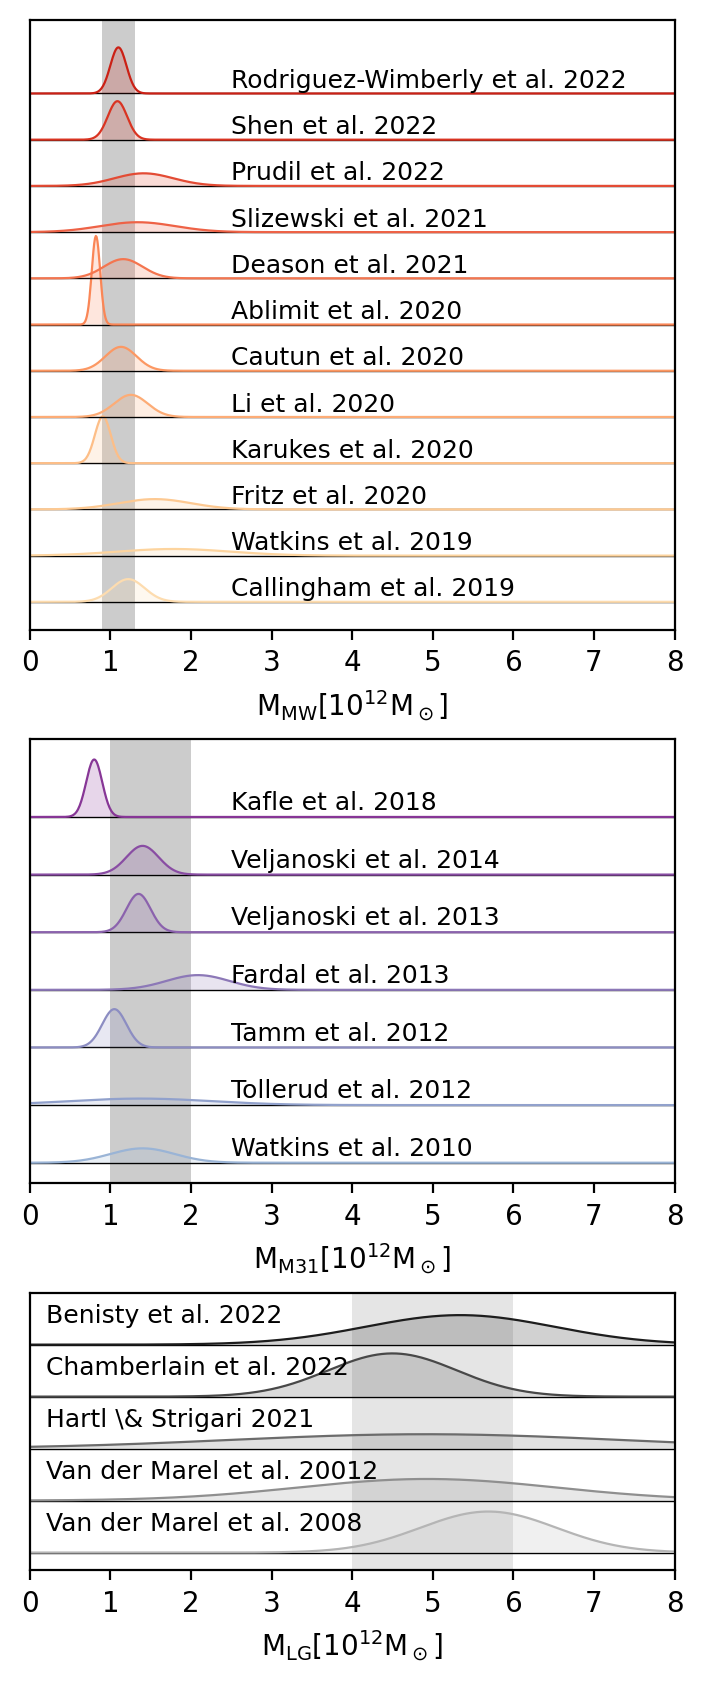

In [13]:
fig, ax = plt.subplots(figsize=(SingleColumn, 8.3), ncols=1, nrows=3, dpi=dpi, gridspec_kw={'height_ratios': [5.5, 4, 2.5]}, constrained_layout = True)

# MW

colors = cm.OrRd(np.linspace(.2, .9, 14))

data_MW = [[1.17, 0.21, 0.15], # callingham
           [1.52, 0.75, 0.44], # watkins
           [1.51, 0.45, .40], # fritz
           [0.89, 0.1, 0.08], # karukes
           [1.23, 0.21, 0.18], # li
           [1.08, 0.20, 0.14], # cautun
           [0.822, 0.052, 0.052], # ablimit
           [1.16, 0.24, 0.24], # Deason
           [1.19, 0.49, 0.32], # Slizewski 
           [1.26, 0.4, 0.22], # Prudil
           [1.08, 0.12, 0.11], #Shen
           [1.1, 0.1, 0.1] ] # Rodriguez

data_MW = np.array(data_MW)

data_MW_text = ['Callingham et al. 2019',
                'Watkins et al. 2019',
                'Fritz et al. 2020',
                'Karukes et al. 2020',
                'Li et al. 2020',
                'Cautun et al. 2020',
                'Ablimit et al. 2020',
                'Deason et al. 2021',
                'Slizewski et al. 2021',
                'Prudil et al. 2022',
                'Shen et al. 2022',
                'Rodriguez-Wimberly et al. 2022']      

N_MW = len(data_MW[:,1])

data_MW_a = -2*(data_MW[:,2] - data_MW[:,1] ) / (data_MW[:,2] + data_MW[:,1])

x = np.arange(0, 8, .01)

scalefactor = 4.
space = .5

for i in range(N_MW):
    
    rv = skewnorm(loc = data_MW[i,0], scale = data_MW[i,1], a=data_MW_a[i])

    ax[0].axhline(i*scalefactor, c='black', lw= 0.5)
    ax[0].plot(x, rv.pdf(x)  + i*scalefactor, c = colors[i], lw=.8, zorder=2)
    ax[0].fill_between(x, i*scalefactor, rv.pdf(x) + i*scalefactor, facecolor = colors[i], alpha = .2, zorder=2)
    ax[0].text(2.5, i*scalefactor + space, data_MW_text[i], fontsize=9)

ax[0].axvspan(0.9, 1.3, facecolor='black', lw= 0.5, alpha=0.2, zorder=1)

    
# M31

colors = cm.BuPu(np.linspace(.4, .9, 9))

data_M31 = [[1.4, 0.4, 0.4], # watkins
            [1.2, 0.9, 0.7], # tollerud
            [1.05, 0.15, 0.15], # tamm
            [2.0, 0.4, .30], # Fardal
            [1.35, 0.15, 0.15], # veljanoski 13
            [1.4, 0.2, 0.2], # veljanoski 14
            [0.8, 0.1, 0.1]] # Kafle 
           
data_M31 = np.array(data_M31)
    

data_M31_text = ['Watkins et al. 2010',
                'Tollerud et al. 2012',
                'Tamm et al. 2012',
                'Fardal et al. 2013',
                'Veljanoski et al. 2013',
                'Veljanoski et al. 2014',
                'Kafle et al. 2018']      

N_M31 = len(data_M31[:,1])

data_M31_a = -2*(data_M31[:,2] - data_M31[:,1] ) / (data_M31[:,2] + data_M31[:,1])

x = np.arange(0, 8, .01)

scalefactor = 4.
space = .5

for i in range(N_M31):
    
    rv = skewnorm(loc = data_M31[i,0], scale = data_M31[i,1], a=data_M31_a[i])
    
    ax[1].axhline(i*scalefactor, c='black', lw= 0.5)
    ax[1].plot(x, rv.pdf(x)  + i*scalefactor, c = colors[i], lw=.8, zorder=2)
    ax[1].fill_between(x, i*scalefactor, rv.pdf(x) + i*scalefactor, facecolor = colors[i], alpha = .2, zorder=2)
    ax[1].text(2.5, i*scalefactor + space, data_M31_text[i], fontsize=9)
    
ax[1].axvspan(1.0, 2.0, facecolor='black', edgecolor='none', lw= 0.5, alpha=0.2, zorder=1)

# LG

colors = cm.Greys(np.linspace(.4, .9, 5))

data_LG = [[5.58, .85, .72], # vdM 2008
           [4.93, 1.6, 1.6], # vDM 2012
           [4.75, 2.41, 2.22], # Hartl-Strigari 2021
           [4.5, 0.8, 0.8], # Chamberlain 2022
           [5.6, 1.2, 1.6]] # Benisty 2022
           
data_LG = np.array(data_LG)
    

data_LG_text = ['Van der Marel et al. 2008',
                'Van der Marel et al. 20012',
                'Hartl \& Strigari 2021',
                'Chamberlain et al. 2022',
                'Benisty et al. 2022']      

N_LG = len(data_LG[:,1])

data_LG_a = -2*(data_LG[:,2] - data_LG[:,1] ) / (data_LG[:,2] + data_LG[:,1])
    
x = np.arange(0, 8, .01)

scalefactor = .6
space = .25

for i in range(N_LG):
    
    rv = skewnorm(loc = data_LG[i,0], scale = data_LG[i,1], a=data_LG_a[i])
    
    ax[2].axhline(i*scalefactor, c='black', lw= 0.5)
    ax[2].plot(x, rv.pdf(x)  + i*scalefactor, c = colors[i], lw=.8, zorder=2)
    ax[2].fill_between(x, i*scalefactor, rv.pdf(x) + i*scalefactor, facecolor = colors[i], alpha = .2, zorder=2)
    ax[2].text(0.2, i*scalefactor + space, data_LG_text[i], fontsize=9)

ax[2].set_ylim(-.2,3.)

for i in range(3):
    ax[i].set_xticks(np.linspace(0,8,9))
    ax[i].set_xlim(0,8)
    ax[i].set_yticks([])
    
ax[0].set_xlabel(r'$\mathrm{M_{MW} [10^{12} M_\odot]}$')
ax[1].set_xlabel(r'$\mathrm{M_{M31} [10^{12} M_\odot]}$')
ax[2].set_xlabel(r'$\mathrm{M_{LG} [10^{12} M_\odot]}$')

ax[2].axvspan(4., 6., facecolor='black', edgecolor='none', lw= 0.5, alpha=0.1, zorder=1)

plt.savefig(plot_directory+'/literature_mass_estimates_gaussian.pdf')

### X-Y distribution _(Figure 2)_  <a id='PlotXYDistribution'></a>  (back to [Contents](#Contents))

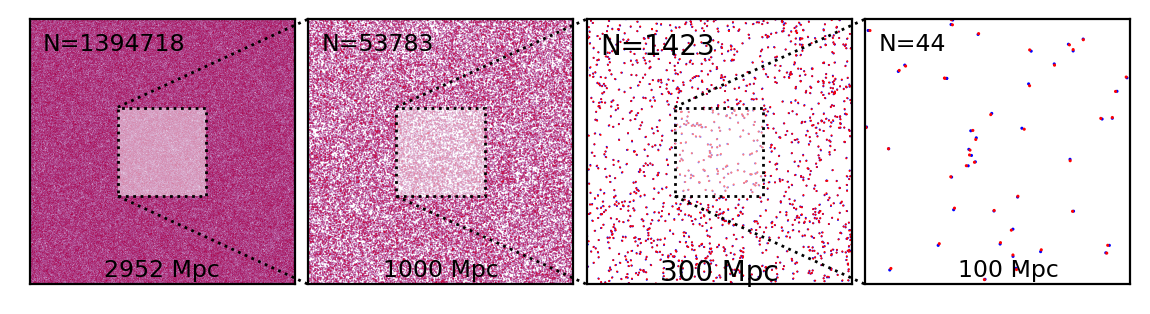

In [14]:
center = 1.5e6 # center in kpc
    
fig, ax = plt.subplots(figsize=(DoubleColumn,4), ncols=4, nrows=1, dpi=dpi, gridspec_kw={'width_ratios': [10, 10, 10, 10]})

#all 3^3 Gpc^3

slice = np.where (LG_pos_MW[:,2] > 0)[0]

N = len(slice)

ax[0].scatter(LG_pos_MW[slice,0] / 1000, LG_pos_MW[slice,1] / 1000 , color='blue', edgecolor='none', s=0.1, alpha = 0.2, marker='.', rasterized=True, zorder=0)
ax[0].scatter(LG_pos_M31[slice,0] / 1000, LG_pos_M31[slice,1] / 1000 , color='red', edgecolor='none', s=0.1, alpha = 0.2, marker='.', rasterized=True, zorder=0)
ax[0].text(0.05, 0.95, 'N='+str(len(LG_M_tot)),  ha='left', va='top', transform=ax[0].transAxes, fontsize=8.5)
ax[0].text(0.5, 0.1, str(int(boxSize/1000.))+' Mpc', ha='center', va='top', transform=ax[0].transAxes, fontsize=8.5)

ax[0].set_xlim(0,boxSize/1000)
ax[0].set_ylim(0,boxSize/1000)

#ax[1] = fig.add_axes([0.47, 0.05, 0.5, 0.915])

# 1^3 Gpc^3

slice = np.where ((LG_pos_MW[:,0] > center-.5e6) & (LG_pos_MW[:,0] < center+.5e6) & 
                  (LG_pos_MW[:,1] > center-.5e6) & (LG_pos_MW[:,1] < center+.5e6) &
                  (LG_pos_MW[:,2] > center-.5e6) & (LG_pos_MW[:,2] < center+.5e6) )[0]

N = len(slice)

ax[1].scatter(LG_pos_MW[slice,0] / 1000, LG_pos_MW[slice,1] / 1000 , color='blue', edgecolor='none', s=1, alpha = 0.3, marker='.', rasterized=True)
ax[1].scatter(LG_pos_M31[slice,0] / 1000, LG_pos_M31[slice,1] / 1000 , color='red', edgecolor='none', s=1, alpha = 0.3, marker='.', rasterized=True)
ax[1].text(0.05, 0.95, 'N='+str(N),  ha='left', va='top', transform=ax[1].transAxes, fontsize=8.5)
ax[1].text(0.5, 0.1, '1000 Mpc',  ha='center', va='top', transform=ax[1].transAxes, fontsize=8.5)


# 0.3^3 Gpc^3

slice = np.where ((LG_pos_MW[:,0] > center-1.5e5) & (LG_pos_MW[:,0] < center+1.5e5) & 
                  (LG_pos_MW[:,1] > center-1.5e5) & (LG_pos_MW[:,1] < center+1.5e5) &
                  (LG_pos_MW[:,2] > center-1.5e5) & (LG_pos_MW[:,2] < center+1.5e5) )[0]

N = len(slice)

ax[2].scatter(LG_pos_MW[slice,0] / 1000, LG_pos_MW[slice,1] / 1000 , color='blue', edgecolor='none', s=2, alpha = 1, marker='.', rasterized=True)
ax[2].scatter(LG_pos_M31[slice,0] / 1000, LG_pos_M31[slice,1] / 1000 , color='red', edgecolor='none', s=2, alpha = 1, marker='.', rasterized=True)
ax[2].text(0.05, 0.95, 'N='+str(N),  ha='left', va='top', transform=ax[2].transAxes)
ax[2].text(0.5, 0.1, '300 Mpc', ha='center', va='top', transform=ax[2].transAxes)


# 0.1^3 Gpc^3

slice = np.where ((LG_pos_MW[:,0] > center-.5e5) & (LG_pos_MW[:,0] < center+.5e5) & 
                  (LG_pos_MW[:,1] > center-.5e5) & (LG_pos_MW[:,1] < center+.5e5) &
                  (LG_pos_MW[:,2] > center-.5e5) & (LG_pos_MW[:,2] < center+.5e5) )[0]

N = len(slice)

ax[3].scatter(LG_pos_MW[slice,0] / 1000, LG_pos_MW[slice,1] / 1000 , color='blue', edgecolor='none', s=5, alpha = 1, marker='.', rasterized=True)
ax[3].scatter(LG_pos_M31[slice,0] / 1000, LG_pos_M31[slice,1] / 1000 , color='red', edgecolor='none', s=5, alpha = 1, marker='.', rasterized=True)
ax[3].text(0.05, 0.95, 'N='+str(N),  ha='left', va='top', transform=ax[3].transAxes, fontsize=8.5)
ax[3].text(0.35, 0.1, '100 Mpc',  ha='left', va='top', transform=ax[3].transAxes, fontsize=8.5)

center = 1500 # now in Mpc

ax[1].set_xlim(center-5e2,center+5e2)
ax[1].set_ylim(center-5e2,center+5e2)

ax[2].set_xlim(center-1.5e2,center+1.5e2)
ax[2].set_ylim(center-1.5e2,center+1.5e2)

ax[3].set_xlim(center-5e1,center+5e1)
ax[3].set_ylim(center-5e1,center+5e1)

# draw boxes and lines for the "loupe"

for i in range (3):
    
    rectangle_face = plt.Rectangle((0.5-.16777,0.5-.16777), 0.33333, 0.3333, fc='white',ec="none", ls='dotted', alpha=.5, transform=ax[i].transAxes)
    rectangle_edge = plt.Rectangle((0.5-.16777,0.5-.16777), 0.33333, 0.3333, fc='none',ec="black", ls='dotted', transform=ax[i].transAxes)
    
    ax[i].add_patch(rectangle_face)
    ax[i].add_patch(rectangle_edge)
    
    ax[i].plot((0.5-.16777,1.05), (0.5+.16777,1), c='black', ls='dotted', lw=1, alpha=1, transform=ax[i].transAxes, clip_on=False)
    ax[i].plot((0.5-.16777,1.05), (0.5-.16777,0), c='black', ls='dotted', lw=1, alpha=1, transform=ax[i].transAxes, clip_on=False)

for i in range(4):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_aspect('equal')

plt.subplots_adjust(bottom=0.05, wspace=0.05)

plt.savefig(plot_directory+'/uchuu_x_y_100_full.pdf', bbox_inches = 'tight')

### 2D Distribution of kinematics for Tidally Dominant and subdominant subsets _(Figure 3)_ <a id='2DKinematicsTidal'></a> (back to [Contents](#Contents))

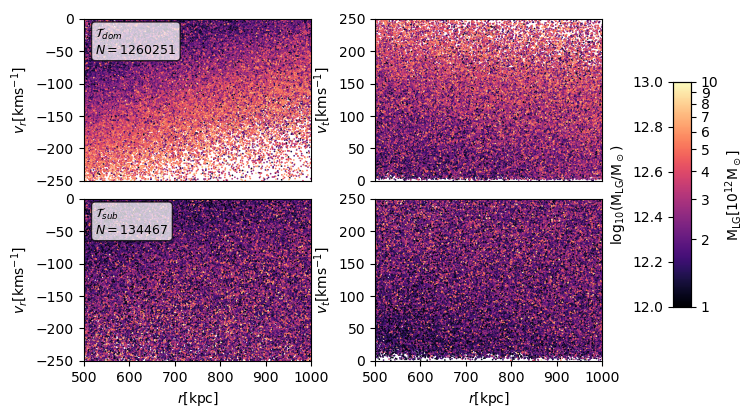

In [15]:
N_scatter = 100000

fig, ax = plt.subplots(figsize=(DoubleColumn,4.5), ncols=3, nrows=2, dpi=100, gridspec_kw={'width_ratios': [10, 10, 2], 'height_ratios':[1,1]})

# scatter, tidally dominant
selection = selection_tidal_dom

x = LG_r[selection][0:N_scatter]
y = LG_vr[selection][0:N_scatter]
c = cmap( norm(np.log10(LG_M_tot[selection][0:N_scatter]) ) )

im= ax[0,0].scatter(x, y, c=c, edgecolor='none', s=6., marker='.', rasterized="true" )
ax[0,0].set_ylabel(r'$v_r \left[\mathrm{kms^{-1}}\right]$')
ax[0,0].set_xticks([])

x = LG_r[selection][0:N_scatter]
y = LG_vt[selection][0:N_scatter]

im= ax[0,1].scatter(x, y, c=c, edgecolor='none', vmax=vmax, s=6., marker='.', rasterized="true" )
ax[0,1].set_ylabel(r'$v_t \left[\mathrm{kms^{-1}}\right]$')
ax[0,1].set_xticks([])

textstr=(textstr_tidal_dom+'\n'+r'$N=$'+str(len(selection)))
ax[0,0].text(0.05, 0.95, textstr, transform=ax[0,0].transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

ax[0,0].set_xlim(r_min, r_max)
ax[0,0].set_ylim(vr_min, vr_max)
ax[0,1].set_xlim(r_min, r_max)
ax[0,1].set_ylim(0, vt_max)


# scatter, tidally subdominant
selection = selection_tidal_sub

x = LG_r[selection][0:N_scatter]
y = LG_vr[selection][0:N_scatter]
c = cmap( norm(np.log10(LG_M_tot[selection][0:N_scatter]) ) )

im= ax[1,0].scatter(x, y, c=c, edgecolor='none',  s=6., marker='.', rasterized="true" )
ax[1,0].set_ylabel(r'$v_r \left[\mathrm{kms^{-1}}\right]$')
ax[1,0].set_xlabel(r'$r \left[\mathrm{kpc}\right]$')


x = LG_r[selection][0:N_scatter]
y = LG_vt[selection][0:N_scatter]

im= ax[1,1].scatter(x, y, c=c, edgecolor='none',  s=6., marker='.',  rasterized="true" )
ax[1,1].set_ylabel(r'$v_t \left[\mathrm{kms^{-1}}\right]$')
ax[1,1].set_xlabel(r'$r \left[\mathrm{kpc}\right]$')

textstr=(textstr_tidal_sub+'\n'+r'$N=$'+str(len(selection)))
ax[1,0].text(0.05, 0.95, textstr, transform=ax[1,0].transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

ax[1,0].set_xlim(r_min, r_max)
ax[1,0].set_ylim(vr_min, vr_max)
ax[1,1].set_xlim(r_min, r_max)
ax[1,1].set_ylim(0, vt_max)

# color bar

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax[1,2])
ax[1,2].set_ylabel(r'$\mathrm{log_{10}\left(M_{LG}/M_\odot\right)}$')
ax[1,2].yaxis.set_label_position("left")

ax[0,2].axis('off')

ax2 = ax[1,2].twinx() # ax1 and ax2 share x-axis
ax2.set_ylabel(r'$\mathrm{M_{LG}} [10^{12} \mathrm{M_\odot}]$')
ax2.set_yscale('log')
ax2.yaxis.set_major_formatter(ScalarFormatter())
ax2.ticklabel_format(style='plain')
ax2.set_yticks(np.arange(1,11))
ax2.set_yticklabels(map(str, np.arange(1,11)))
ax2.set_ylim(1,10)
ax2.yaxis.set_label_position("right")

ax[0,0].set_position([0.1,0.5, 0.32, 0.36])
ax[0,1].set_position([0.51,0.5, 0.32, 0.36])
ax[1,0].set_position([0.1,0.1, 0.32, 0.36])
ax[1,1].set_position([0.51,0.1, 0.32, 0.36])
ax[1,2].set_position([0.93,0.22, 0.025, 0.5])

plt.savefig(plot_directory+'/uchuu_r_vr_vt_tidal_dominance.pdf', bbox_inches='tight')

### 2D Distribution of kinematics for different high and low force ratio subsets _(Figure 4)_ <a id='2DKinematicsForceRatio'></a> (back to [Contents](#Contents))

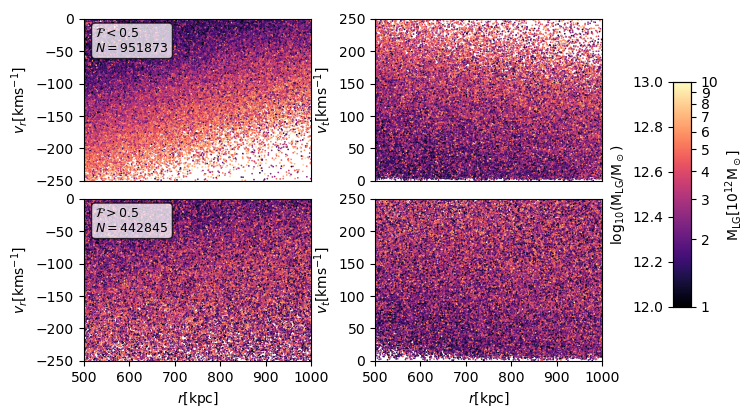

In [16]:
fig, ax = plt.subplots(figsize=(DoubleColumn,4.5), ncols=3, nrows=2, dpi=100, gridspec_kw={'width_ratios': [10, 10, 2], 'height_ratios':[1,1]})

N_scatter = 100000

# scatter, low force ratio
selection = selection_force_low

x = LG_r[selection][0:N_scatter]
y = LG_vr[selection][0:N_scatter]
c = cmap( norm(np.log10(LG_M_tot[selection][0:N_scatter]) ) )

im= ax[0,0].scatter(x, y, c=c, edgecolor='none', s=6., marker='.', rasterized="true" )
ax[0,0].set_ylabel(r'$v_r \left[\mathrm{kms^{-1}}\right]$')
ax[0,0].set_xticks([])

x = LG_r[selection][0:N_scatter]
y = LG_vt[selection][0:N_scatter]

im= ax[0,1].scatter(x, y, c=c, edgecolor='none', vmax=vmax, s=6., marker='.', rasterized="true" )
ax[0,1].set_ylabel(r'$v_t \left[\mathrm{kms^{-1}}\right]$')
ax[0,1].set_xticks([])

textstr=(textstr_force_low+'\n'+r'$N=$'+str(len(selection_force_low)))
ax[0,0].text(0.05, 0.95, textstr, transform=ax[0,0].transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

ax[0,0].set_xlim(r_min, r_max)
ax[0,0].set_ylim(vr_min, vr_max)
ax[0,1].set_xlim(r_min, r_max)
ax[0,1].set_ylim(0, vt_max)


# scatter, high force ratio
selection = selection_force_high

x = LG_r[selection][0:N_scatter]
y = LG_vr[selection][0:N_scatter]
c = cmap( norm(np.log10(LG_M_tot[selection][0:N_scatter]) ) )

im= ax[1,0].scatter(x, y, c=c, edgecolor='none',  s=6., marker='.', rasterized="true" )
ax[1,0].set_ylabel(r'$v_r \left[\mathrm{kms^{-1}}\right]$')
ax[1,0].set_xlabel(r'$r \left[\mathrm{kpc}\right]$')

x = LG_r[selection][0:N_scatter]
y = LG_vt[selection][0:N_scatter]

im= ax[1,1].scatter(x, y, c=c, edgecolor='none',  s=6., marker='.',  rasterized="true" )
ax[1,1].set_ylabel(r'$v_t \left[\mathrm{kms^{-1}}\right]$')
ax[1,1].set_xlabel(r'$r \left[\mathrm{kpc}\right]$')

textstr=(textstr_force_high+'\n'+r'$N=$'+str(len(selection_force_high)))
ax[1,0].text(0.05, 0.95, textstr, transform=ax[1,0].transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

ax[1,0].set_xlim(r_min, r_max)
ax[1,0].set_ylim(vr_min, vr_max)
ax[1,1].set_xlim(r_min, r_max)
ax[1,1].set_ylim(0, vt_max)


# color bar

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax[1,2])
ax[1,2].set_ylabel(r'$\mathrm{log_{10}\left(M_{LG}/M_\odot\right)}$')
ax[1,2].yaxis.set_label_position("left")

ax[0,2].axis('off')

ax2 = ax[1,2].twinx() # ax1 and ax2 share x-axis
ax2.set_ylabel(r'$\mathrm{M_{LG}} [10^{12} \mathrm{M_\odot}]$')
ax2.set_yscale('log')
ax2.yaxis.set_major_formatter(ScalarFormatter())
ax2.ticklabel_format(style='plain')
ax2.set_yticks(np.arange(1,11))
ax2.set_yticklabels(map(str, np.arange(1,11)))
ax2.set_ylim(1,10)
ax2.yaxis.set_label_position("right")

ax[0,0].set_position([0.1,0.5, 0.32, 0.36])
ax[0,1].set_position([0.51,0.5, 0.32, 0.36])
ax[1,0].set_position([0.1,0.1, 0.32, 0.36])
ax[1,1].set_position([0.51,0.1, 0.32, 0.36])
ax[1,2].set_position([0.93,0.22, 0.025, 0.5])

ax[0,2].axis('off')

plt.savefig(plot_directory+'/uchuu_r_vr_vt_force_ratio.pdf', bbox_inches='tight')

### Histograms of kinematic properties as measured in the simulation, for different subsets _(Figure 5)_ <a id='HistogramsKinematics'></a> (back to [Contents](#Contents))

max_x, min_x 1000.0 500.0
vt percentiles full: -45.83422730017145 81.17093369445467 73.1800653652507
vt percentiles subdominant: -68.10259680963293 117.6238787544111 82.92285964140052
vt high force: -59.14648758381313 107.03090258100782 77.78571957124826
vt percentiles true: -40.1120889527504 71.98708034888281 64.14858440359964


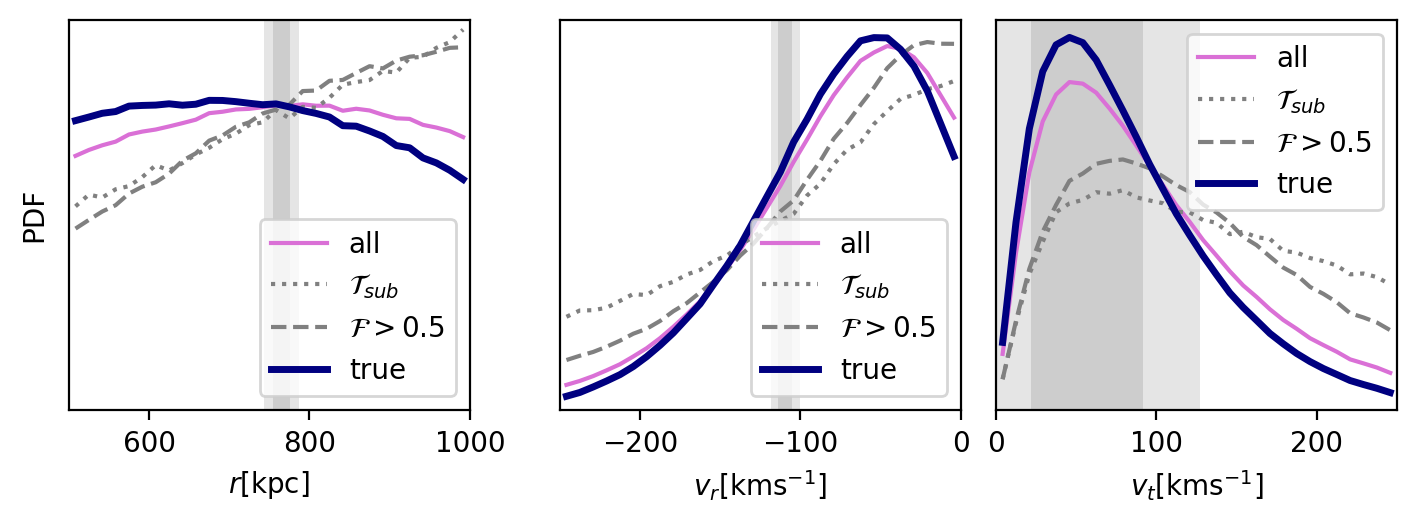

In [17]:
fig, ax = plt.subplots(figsize=(DoubleColumn,2.5), ncols=3, nrows=1, dpi=dpi, constrained_layout = True)

# r

min_x = r_min 
max_x = r_max

print ("max_x, min_x", max_x, min_x)

samples = LG_r
h,e = np.histogram(samples, bins=30, density=True, range=(min_x,max_x))
centers = (e[1:] + e[:-1])/2
ax[0].plot(centers, h, c='orchid', lw=1.5, ls='solid', label='all', zorder=2)

selection = selection_tidal_sub
samples = LG_r[selection]
h,e = np.histogram(samples, bins=30, density=True, range=(min_x,max_x))
centers = (e[1:] + e[:-1])/2
ax[0].plot(centers, h, c='grey', lw=1.5, ls='dotted', label=r'$\mathcal{T}_{sub}$', zorder=2)

selection = selection_force_high
samples = LG_r[selection]
h,e = np.histogram(samples, bins=30, density=True, range=(min_x,max_x))
centers = (e[1:] + e[:-1])/2
ax[0].plot(centers, h, c='grey', lw=1.5, ls='dashed', label=r'$\mathcal{F} > 0.5$', zorder=2)

selection = selection_true
samples = LG_r[selection]
h,e = np.histogram(samples, bins=30, density=True, range=(min_x,max_x))
centers = (e[1:] + e[:-1])/2
ax[0].plot(centers, h, c='navy', lw=2.5, ls='solid', label=r'true', zorder=2)

ax[0].axvspan(r_obs[0]-r_obs[1], r_obs[0]+r_obs[1], edgecolor='none', facecolor=(0, 0, 0, 0.1))
ax[0].axvspan(r_obs[0]-2*r_obs[1], r_obs[0]+2*r_obs[1], edgecolor='none', facecolor=(0, 0, 0, 0.1))

ax[0].set_xlim(min_x,max_x)
ax[0].set_ylim(bottom=0)

ax[0].set_xlabel(r'$r [\mathrm{kpc}]$')
ax[0].set_ylabel('PDF')
ax[0].set_yticks([])
ax[0].legend(loc='lower right')


# vr

min_x = vr_min 
max_x = vr_max

samples = LG_vr
h,e = np.histogram(samples, bins=30, density=True, range=(min_x,max_x))
centers = (e[1:] + e[:-1])/2
ax[1].plot(centers, h, c='orchid', lw=1.5, ls='solid', label='all', zorder=2)

selection = selection_tidal_sub
samples = LG_vr[selection]
h,e = np.histogram(samples, bins=30, density=True, range=(min_x,max_x))
centers = (e[1:] + e[:-1])/2
ax[1].plot(centers, h, c='grey', lw=1.5, ls='dotted', label=r'$\mathcal{T}_{sub}$', zorder=2)

selection = selection_force_high
samples = LG_vr[selection]
h,e = np.histogram(samples, bins=30, density=True, range=(min_x,max_x))
centers = (e[1:] + e[:-1])/2
ax[1].plot(centers, h, c='grey', lw=1.5, ls='dashed', label=r'$\mathcal{F} > 0.5$', zorder=2)

selection = selection_true
samples = LG_vr[selection]
h,e = np.histogram(samples, bins=30, density=True, range=(min_x,max_x))
centers = (e[1:] + e[:-1])/2
ax[1].plot(centers, h, c='navy', lw=2.5, ls='solid', label=r'true', zorder=2)

ax[1].axvspan(vr_obs[0]-vr_obs[1], vr_obs[0]+vr_obs[1],  edgecolor='none', facecolor=(0, 0, 0, 0.1))
ax[1].axvspan(vr_obs[0]-2*vr_obs[1], vr_obs[0]+2*vr_obs[1],  edgecolor='none', facecolor=(0, 0, 0, 0.1))

ax[1].set_xlim(min_x,max_x)
ax[1].set_ylim(bottom=0)

ax[1].set_xlabel(r'$v_r [\mathrm{kms^{-1}}]$')
ax[1].set_yticks([])
ax[1].legend(loc='lower right')


# vt

min_x = 0
max_x = vt_max

samples = LG_vt
h,e = np.histogram(samples, bins=30, density=True, range=(min_x,max_x))
centers = (e[1:] + e[:-1])/2
ax[2].plot(centers, h, c='orchid', lw=1.5, ls='solid', label='all', zorder=2)

low, med, high = np.percentile(samples, (16., 50, 84.)) 
low = low-med
high = high-med

print ("vt percentiles full:", low, med, high)

selection = selection_tidal_sub
samples = LG_vt[selection]
h,e = np.histogram(samples, bins=30, density=True, range=(min_x,max_x))
centers = (e[1:] + e[:-1])/2
ax[2].plot(centers, h, c='grey', lw=1.5, ls='dotted', label=r'$\mathcal{T}_{sub}$', zorder=2)

low, med, high = np.percentile(samples, (16., 50, 84.)) 
low = low-med
high = high-med
print ("vt percentiles subdominant:", low, med, high)

selection = selection_force_high
samples = LG_vt[selection]
h,e = np.histogram(samples, bins=30, density=True, range=(min_x,max_x))
centers = (e[1:] + e[:-1])/2
ax[2].plot(centers, h, c='grey', lw=1.5, ls='dashed', label=r'$\mathcal{F} > 0.5$', zorder=2)

low, med, high = np.percentile(samples, (16., 50, 84.)) 
low = low-med
high = high-med
print ("vt high force:", low, med, high)

selection = selection_true
samples = LG_vt[selection]
h,e = np.histogram(samples, bins=30, density=True, range=(min_x,max_x))
centers = (e[1:] + e[:-1])/2

low, med, high = np.percentile(samples, (16., 50, 84.)) 
low = low-med
high = high-med

print ("vt percentiles true:", low, med, high)


ax[2].plot(centers, h, c='navy', lw=2.5, ls='solid', label='true', zorder=2)

ax[2].axvspan(vt_obs[0]-vt_obs[1], vt_obs[0]+vt_obs[1], edgecolor='none', facecolor=(0, 0, 0, 0.1))
ax[2].axvspan(vt_obs[0]-2*vt_obs[1], vt_obs[0]+2*vt_obs[1], edgecolor='none', facecolor=(0, 0, 0, 0.1))

ax[2].set_xlim(min_x,max_x)
ax[2].set_ylim(bottom=0)

ax[2].set_xlabel(r'$v_t [\mathrm{kms^{-1}}]$')
ax[2].set_yticks([])
ax[2].legend(loc='upper right')


plt.savefig(plot_directory+'/uchuu_r_vr_vt_histograms.pdf', bbox_inches='tight')



### Plot the predicted vs simulated 2D distribution of mass and kinematics _(Figure 6)_  <a id='GaussianScatterComparison'></a> (back to [Contents](#Contents))

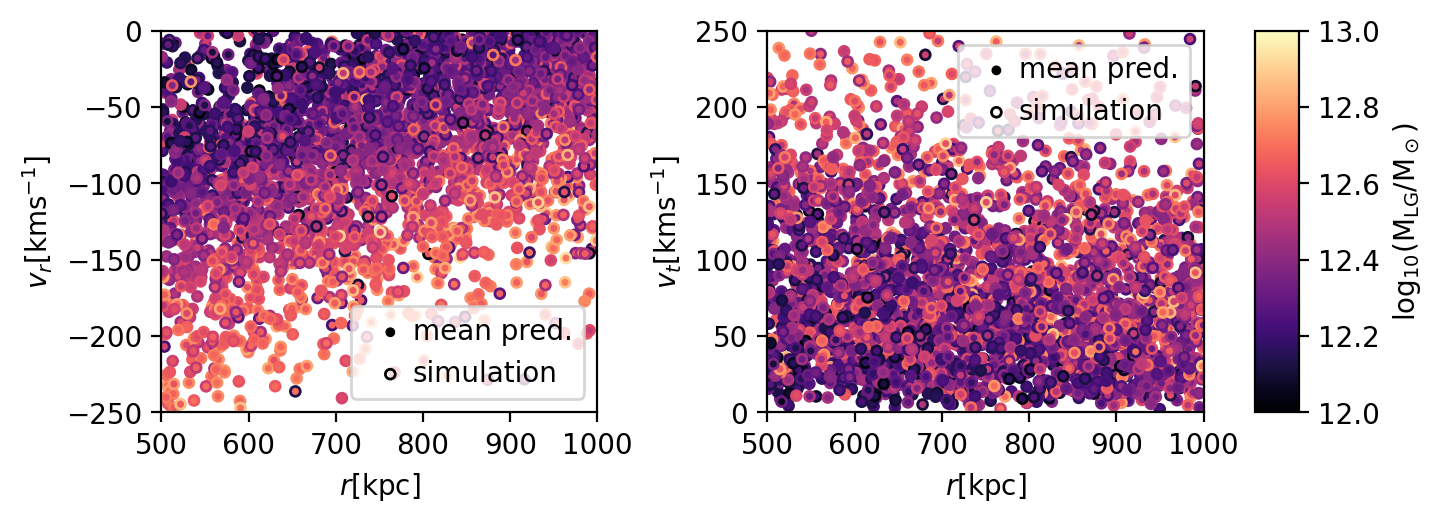

In [18]:
# we use 3000 points for the plot, independent of the size of the training / testing data

N_pred = 3000
selection = selection_true[0:N_pred]

vt = LG_vt[selection]
vr = LG_vr[selection]
r = LG_r[selection]
LogM = np.log10(LG_M_tot[selection])

# Mean Prediction
X = np.array([r, vr, vt]).T
X_scale = x_scaler.transform(X)

# create prediction
mean_prediction_scaled, std_prediction_scale = gaussian_process.predict(X_scale, return_std=True)

# inverse scale the prediction
mean_prediction = y_scaler.inverse_transform(mean_prediction_scaled.reshape(-1, 1) )
mean_prediction = np.array(mean_prediction)
std_prediction = std_prediction_scale * b_minus_a

fig, ax = plt.subplots(figsize=(DoubleColumn,2.5), ncols=3, nrows=1, dpi=dpi, gridspec_kw={'width_ratios': [10, 10, 1]}, constrained_layout = True)

x = r
y = vr
c_in = cmap( norm(mean_prediction) ) #center
c_out = cmap( norm(LogM) ) #edge

im= ax[0].scatter(x, y, facecolor=c_in, edgecolor=c_out, s=50., marker='.', lw=1., rasterized="true")

empty = ax[0].scatter([-2], [-2], facecolor='black', edgecolor='none', s=50., marker='.', lw=1., rasterized="false", label = 'mean pred.')  # center
empty = ax[0].scatter([-2], [-2], facecolor='none', edgecolor='black', s=50., marker='.', lw=1., rasterized="false", label = 'simulation')        # edge

ax[0].set_xlim(500,1000)
ax[0].set_ylim(-250,0)

ax[0].legend(loc = 'lower right', handletextpad=-0.2)
ax[0].set_ylabel(r'$v_r \left[\mathrm{kms^{-1}}\right]$')
ax[0].set_xlabel(r'$r \left[\mathrm{kpc}\right]$')

x = r
y = vt

c_in = cmap( norm(mean_prediction) ) #center
c_out = cmap( norm(LogM) ) #edge

im= ax[1].scatter(x, y, facecolor=c_in, edgecolor=c_out, s=50., marker='.', lw=1., rasterized="true")
empty = ax[1].scatter([-2], [-2], facecolor='black', edgecolor='none', s=50., marker='.', lw=1., rasterized="false", label = 'mean pred.') #center
empty = ax[1].scatter([-2], [-2], facecolor='none', edgecolor='black', s=50., marker='.', lw=1., rasterized="false", label = 'simulation') #edge
                  
ax[1].set_ylabel(r'$v_t \left[\mathrm{kms^{-1}}\right]$')
ax[1].set_xlabel(r'$r \left[\mathrm{kpc}\right]$')

ax[1].legend(loc='upper right', handletextpad=-0.2)

ax[1].set_xlim(500,1000)
ax[1].set_ylim(0,250)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax[2])#, orientation='horizontal', label='Some Units'))
ax[2].set_ylabel(r'$\mathrm{log_{10}\left(M_{LG}/M_\odot\right)}$')

plt.savefig(plot_directory+'/Gaussian_regression_'+TrainingData+'_prediction.pdf')



### Plot results of the median predicted mass of the bootstrapped regressors _(Figure 7)_  <a id='PlotBootstrapGP'></a> (back to [Contents](#Contents))

N 100 , med / std dev: [3.14 0.27]
N 200 , med / std dev: [3.13 0.17]
N 400 , med / std dev: [3.15 0.16]
N 800 , med / std dev: [3.16 0.11]
N 1600 , med / std dev: [3.22 0.09]
N 3200 , med / std dev: [3.18 0.06]


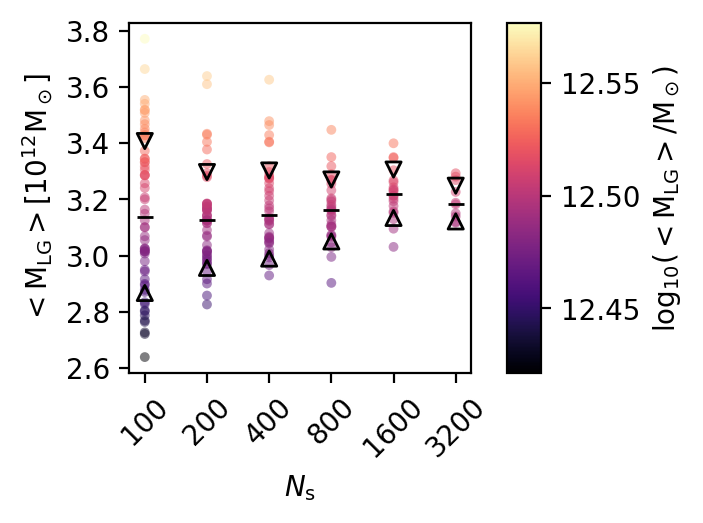

In [19]:
fig, ax = plt.subplots(figsize=(SingleColumn,2.5), ncols=2, nrows=1, dpi=dpi, gridspec_kw={'width_ratios': [10, 1]}, constrained_layout = True)

for i in N_vector:
    f = np.array(pickle.load(open('convolvedmed_vector_'+str(i[0])+'_'+TrainingData+'_'+'N_points_regression_'+str(i[1])+'.pkl', 'rb')))
    if i[0] == N_vector[0][0]:
        vmin = min ( np.log10(f))
        vmax = max ( np.log10(f))
        norm_conv = plt.Normalize(vmin=vmin, vmax=vmax)
    x = np.repeat(i[1], len(f) )
    y = f / 1.e12
    c_in = cmap(norm_conv(np.log10(f)))
    ax[0].scatter(x, y, facecolor=c_in, edgecolor='none', s=50., marker='.', lw=.8, rasterized="true", zorder=50, alpha=.5)
   
    low = np.median(y) - np.std(y)
    med = np.median(y)
    high = np.median(y) + np.std(y)
   
    ax[0].scatter(x[0], high, facecolor='none', edgecolor='black', s=30., marker='v', lw=1, rasterized="true", zorder=100)
    ax[0].scatter(x[0], med, facecolor='black', s=30., marker='_', lw=1, rasterized="true", zorder=100)
    ax[0].scatter(x[0], low, facecolor='none', edgecolor='black', s=30., marker='^', lw=1, rasterized="true", zorder=100)

    print ('N', i[1], ', med / std dev:', np.round ( (med, np.std(y)), 2) )
    
ax[0].set_xscale('log')
ax[0].set_xticks(list(zip(*N_vector))[1])
ax[0].set_yticks([2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8])
ax[0].set_xticklabels(map(str, list(zip(*N_vector))[1]),rotation=45)
ax[0].xaxis.set_major_formatter(ScalarFormatter())
ax[0].ticklabel_format(style='plain')
ax[0].minorticks_off()

ax[0].set_ylabel(r'$<\mathrm{M_{LG}}> [10^{12} \mathrm{M}_\odot]$')
ax[0].set_xlabel(r'$N_\mathrm{s}$')

fig.colorbar(mpl.cm.ScalarMappable(norm=norm_conv, cmap=cmap), cax=ax[1])#, orientation='horizontal', label='Some Units'))
ax[1].set_ylabel(r'$\mathrm{log_{10}\left(<M_{LG}>/M_\odot\right)}$')

plt.savefig(plot_directory+'/Gaussian_regression_convergence.pdf')



### Plot the predicted vs simulated mass, with errors _(Figure 8)_ <a id='PlotErrorsGP'></a> (back to [Contents](#Contents))

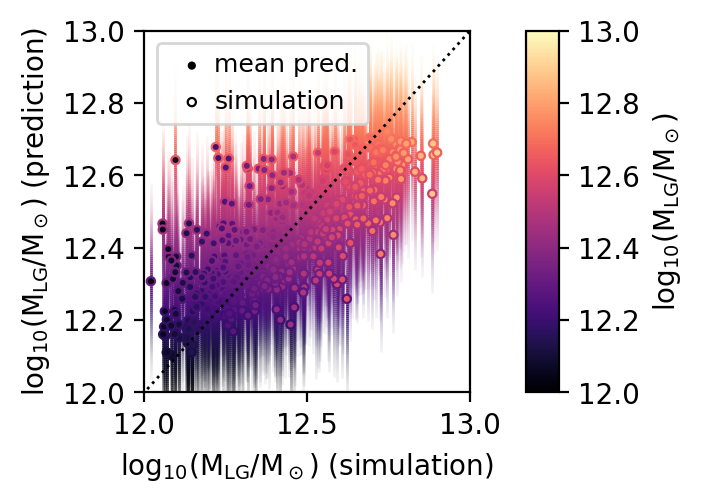

In [20]:
# plot 500 points

fig, ax = plt.subplots(figsize=(SingleColumn,2.4), ncols=2, nrows=1, dpi=dpi, gridspec_kw={'width_ratios': [10, 1]}, constrained_layout = True)

x = LogM[0:500]
y = mean_prediction[0:500]
c = cmap( norm(LogM[0:500]) )

# plot shaded lines to indicate individual errors

N_line_segments = 100 # segments for each ine 

# let's make the alpha depend on the probability
mu = 0
std = 0.5
snd = stats.norm(mu, std)
alpha = snd.pdf(np.linspace(-1,1,N_line_segments))**1.5 * 1.4

for j in range(500):
    
    y_segments = np.linspace(mean_prediction[j] - std_prediction[j]*2, mean_prediction[j] + std_prediction[j]*2, N_line_segments)
    lines = []
  
    for i in range(N_line_segments-1):
        lines.append( [(x[j], y_segments[i]), (x[j],y_segments[i+1])] )
 
    color = cmap( norm( y_segments) )
    
    lc = LineCollection(lines, color=color, lw=1., alpha=alpha, rasterized=True)
    
    ax[0].add_collection(lc)

# add the points
c_in = cmap( norm(x) )
c_out = cmap( norm(y) )
ax[0].scatter(x, y, facecolor=c_in, edgecolor=c_out, s=35., marker='.', lw=.8, rasterized="true", zorder=100)

# add the 1:1 line
ax[0].plot([0,100],[0,100], lw=1, ls = 'dotted', c='black', zorder=1000)

# add the labels
empty = ax[0].scatter([-2], [-2], facecolor='black', edgecolor='none', s=35., marker='.', lw=.8, rasterized="false", label = 'mean pred.') #center
empty = ax[0].scatter([-2], [-2], facecolor='none', edgecolor='black', s=35., marker='.', lw=.8, rasterized="false", label = 'simulation') #edge
ax[0].legend(loc='upper left', handletextpad=-0.1, fontsize=9)

ax[0].set_ylabel(r'$\mathrm{log_{10}\left(M_{LG}/M_\odot\right)}$'+' (prediction)')
ax[0].set_xlabel(r'$\mathrm{log_{10}\left(M_{LG}/M_\odot\right)}$'+' (simulation)')
ax[0].set_xlim(12.0, 13.0)
ax[0].set_ylim(12.0, 13.0)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax[1])#, orientation='horizontal', label='Some Units'))
ax[1].set_ylabel(r'$\mathrm{log_{10}\left(M_{LG}/M_\odot\right)}$')

plt.savefig(plot_directory+'/Gaussian_regression_'+TrainingData+'_mean_error_multicolor.pdf')


### Plot histogram of the simulation mass, and the predicted mass with and without errors _(Figure 9)_ <a id='PlotDistributionsGP'></a> (back to [Contents](#Contents))

median data prediction: 12.40619559907058  -  2.548 x 10E12
generating prediction
finished prediction
$\mathrm{M}=2.6^{+1.6}_{-1.0}$$\times 10^{12} \mathrm{M_\odot}$
c3, data:$\mathrm{M}=3.5^{+1.2}_{-1.1}$$\times 10^{12} \mathrm{M_\odot}$
generating prediction
finished prediction
c3, mean prediction:$\mathrm{M}=3.3^{+0.3}_{-0.3}$$\times 10^{12} \mathrm{M_\odot}$
c3, convolved prediction:$\mathrm{M}=3.3^{+1.3}_{-0.9}$$\times 10^{12} \mathrm{M_\odot}$


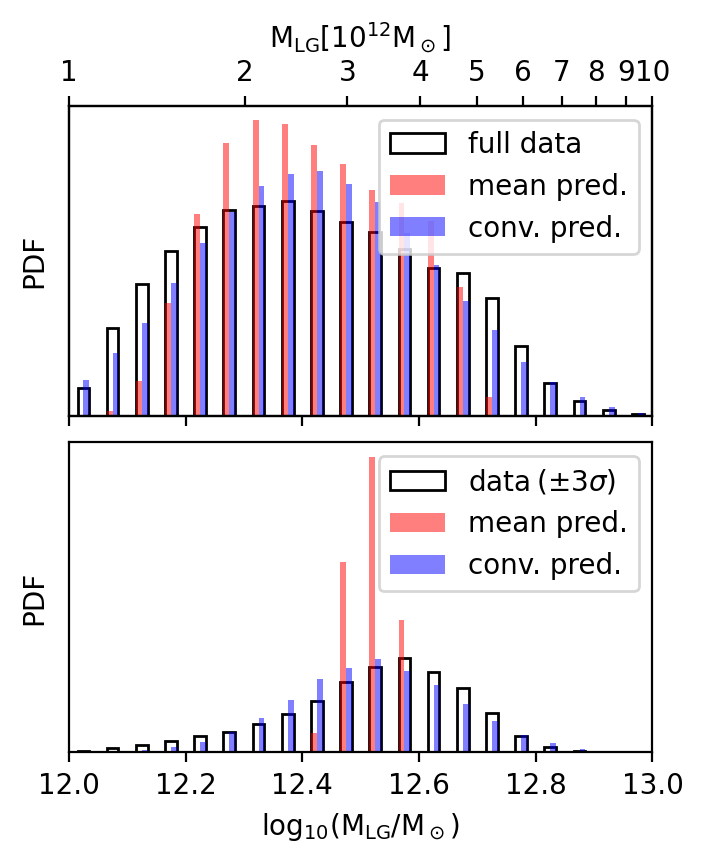

In [21]:
fig, ax = plt.subplots(figsize=(SingleColumn,4.2), ncols=1, nrows=2, dpi=dpi, constrained_layout = True)

# use a larger set
N_pred = 50000

# on top, plot the full data:
selection = selection_true[0:N_pred]

vt = LG_vt[selection]
vr = LG_vr[selection]
r = LG_r[selection]
LogM = np.log10(LG_M_tot[selection])

# Truth

samples = LogM
h,e = np.histogram(samples, bins=20, density=True, range = [12,13])
centers = (e[1:] + e[:-1])/2

low, med, high = np.percentile(samples, (15.86, 50., 84.14))
medstr = str(np.round( 10**(med) / 1.e12 ,1))
highstr = str(np.round( (10**(high) - 10**(med)) / 1.e12 ,1))
lowstr = str(np.round( (10**(low) - 10**(med)) / 1.e12 ,1))
text = r'$\mathrm{M}='+medstr+'^{+'+highstr+'}_{'+lowstr+'}$'+r'$\times 10^{12} \mathrm{M_\odot}$'

ax[0].bar(centers, h, label='full data', zorder=2, width = 0.02, alpha=1., facecolor='white', edgecolor='black')

print ("median data prediction:", np.median(samples), ' - ', str(np.round(10**np.median(samples) / 1.e12, 3))+' x 10E12')

# Mean Prediction

X = np.array([r, vr, vt]).T
X_scale = x_scaler.transform(X)

# create prediction
print ("generating prediction")
mean_prediction_scaled, std_prediction_scale = gaussian_process.predict(X_scale, return_std=True)

# inverse scale the prediction
mean_prediction = y_scaler.inverse_transform(mean_prediction_scaled.reshape(-1, 1) )
mean_prediction = np.array(mean_prediction)
std_prediction = std_prediction_scale * b_minus_a

print ("finished prediction")

samples = mean_prediction
h,e = np.histogram(samples, bins=20, density=True,  range = [12,13])
centers = (e[1:] + e[:-1])/2

low, med, high = np.percentile(samples, (15.86, 50., 84.14))
medstr = str(np.round( 10**(med) / 1.e12 ,1))
highstr = str(np.round( (10**(high) - 10**(med)) / 1.e12 ,1))
lowstr = str(np.round( (10**(low) - 10**(med)) / 1.e12 ,1))
text = r'$\mathrm{M}='+medstr+'^{+'+highstr+'}_{'+lowstr+'}$'+r'$\times 10^{12} \mathrm{M_\odot}$'

ax[0].bar(centers-.005, h, label='mean pred.', zorder=2, width = 0.01, alpha=.5, facecolor='red')
# Convolved Prediction

variables = []

for i in range (len(mean_prediction)):
    variables.append( np.random.normal(loc=mean_prediction[i], scale=std_prediction[i], size=2) )

samples = variables
h,e = np.histogram(samples, bins=20, density=True,  range = [12,13])
centers = (e[1:] + e[:-1])/2

low, med, high = np.percentile(samples, (15.86, 50., 84.14))
medstr = str(np.round( 10**(med) / 1.e12 ,1))
highstr = str(np.round( (10**(high) - 10**(med)) / 1.e12 ,1))
lowstr = str(np.round( (10**(low) - 10**(med)) / 1.e12 ,1))
text = r'$\mathrm{M}='+medstr+'^{+'+highstr+'}_{'+lowstr+'}$'+r'$\times 10^{12} \mathrm{M_\odot}$'

print(text)

ax[0].bar(centers+.005, h, label='conv. pred.', zorder=2, width = 0.01, alpha=.5, facecolor='blue')
ax[0].set_ylim(bottom=0)
ax[0].set_ylabel('PDF')
ax[0].set_xticklabels([])
ax[0].set_yticks([])
ax[0].legend()
ax[0].set_xlim(12.0, 13.0)


ax2 = ax[0].twiny() # for the top x axis labels
ax2.set_xscale('log')
ax2.xaxis.set_major_formatter(ScalarFormatter())
ax2.ticklabel_format(style='plain')
ax2.set_xticks([1, 2, 3, 4, 5, 6, 7, 8,9,10])
ax2.set_xticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
ax2.set_xlim(1,10)
ax2.set_xlabel(r'$\mathrm{M_{LG} [10^{12} M_\odot]}$')


# now, at the bottom, plot only the c3 data

selection = list (set (selection_true) & set(c3_matches) )[0:N_pred]

vt = LG_vt[selection]
vr = LG_vr[selection]
r = LG_r[selection]
LogM = np.log10(LG_M_tot[selection])

# Truth
samples = LogM
h,e = np.histogram(samples, bins=20, density=True, range = [12,13])
centers = (e[1:] + e[:-1])/2

low, med, high = np.percentile(samples, (15.86, 50., 84.14))
medstr = str(np.round( 10**(med) / 1.e12 ,1))
highstr = str(np.round( (10**(high) - 10**(med)) / 1.e12 ,1))
lowstr = str(np.round( (10**(low) - 10**(med)) / 1.e12 ,1))
text = r'$\mathrm{M}='+medstr+'^{+'+highstr+'}_{'+lowstr+'}$'+r'$\times 10^{12} \mathrm{M_\odot}$'

ax[1].bar(centers, h, label='data'+r'$\:(\pm 3 \sigma)$', zorder=2, width = 0.02, alpha=1., facecolor='white', edgecolor='black')

print ("c3, data:"+text)

# Mean Prediction
X = np.array([r, vr, vt]).T
X_scale = x_scaler.transform(X)

# create prediction
print ("generating prediction")
mean_prediction_scaled, std_prediction_scale = gaussian_process.predict(X_scale, return_std=True)

# inverse scale the prediction
mean_prediction = y_scaler.inverse_transform(mean_prediction_scaled.reshape(-1, 1) )
mean_prediction = np.array(mean_prediction)
std_prediction = std_prediction_scale * b_minus_a

print ("finished prediction")

samples = mean_prediction
h,e = np.histogram(samples, bins=20, density=True,  range = [12,13])
centers = (e[1:] + e[:-1])/2

low, med, high = np.percentile(samples, (15.86, 50., 84.14))
medstr = str(np.round( 10**(med) / 1.e12 ,1))
highstr = str(np.round( (10**(high) - 10**(med)) / 1.e12 ,1))
lowstr = str(np.round( (10**(low) - 10**(med)) / 1.e12 ,1))
text = r'$\mathrm{M}='+medstr+'^{+'+highstr+'}_{'+lowstr+'}$'+r'$\times 10^{12} \mathrm{M_\odot}$'

print ("c3, mean prediction:"+text)


ax[1].bar(centers-.005, h, label='mean pred.', zorder=2, width = 0.01, alpha=.5, facecolor='red')

# Convolved Prediction
variables = []

for i in range (len(mean_prediction)):
    variables.append( np.random.normal(loc=mean_prediction[i], scale=std_prediction[i], size=2) )

samples = variables
h,e = np.histogram(samples, bins=20, density=True,  range = [12,13])
centers = (e[1:] + e[:-1])/2

low, med, high = np.percentile(samples, (15.86, 50., 84.14))
medstr = str(np.round( 10**(med) / 1.e12 ,1))
highstr = str(np.round( (10**(high) - 10**(med)) / 1.e12 ,1))
lowstr = str(np.round( (10**(low) - 10**(med)) / 1.e12 ,1))
text = r'$\mathrm{M}='+medstr+'^{+'+highstr+'}_{'+lowstr+'}$'+r'$\times 10^{12} \mathrm{M_\odot}$'

print ("c3, convolved prediction:"+text)

ax[1].bar(centers+.005, h, label='conv. pred.', zorder=2, width = 0.01, alpha=.5, facecolor='blue')
ax[1].set_ylim(bottom=0)
ax[1].set_xlabel(r'$\mathrm{log_{10}\left(M_{LG}/M_\odot\right)}$')
ax[1].set_ylabel('PDF')
ax[1].set_yticks([])
ax[1].legend(loc='upper right')
ax[1].set_xlim(12.0, 13.0)


plt.savefig(plot_directory+'/Gaussian_regression_'+TrainingData+'_histograms.pdf')

### Use the model to predict with MC sampled observations _(Figure 10)_  <a id='PredictMCGP'></a> (back to [Contents](#Contents))

median vt: 57.0
generating predictions
finished predictions for 0 sigma
prediction: [[12.50876512]]
no error, convolved: $3.23^{+1.2}_{-0.9}$$\times 10^{12} \mathrm{M_{\odot}}$
median vt: 59.31466127280041
generating predictions
finished predictions for 1 sigma
1 sigma, mean: $3.26^{+0.2}_{-0.2}$$\times 10^{12} \mathrm{M_{\odot}}$
1 sigma, convolved: $3.27^{+1.2}_{-0.9}$$\times 10^{12} \mathrm{M_{\odot}}$
median vt: 75.69651721106851
generating predictions
finished predictions for 2 sigma
2 sigma, mean: $3.37^{+0.4}_{-0.3}$$\times 10^{12} \mathrm{M_{\odot}}$
2 sigma, convolved: $3.38^{+1.3}_{-0.9}$$\times 10^{12} \mathrm{M_{\odot}}$


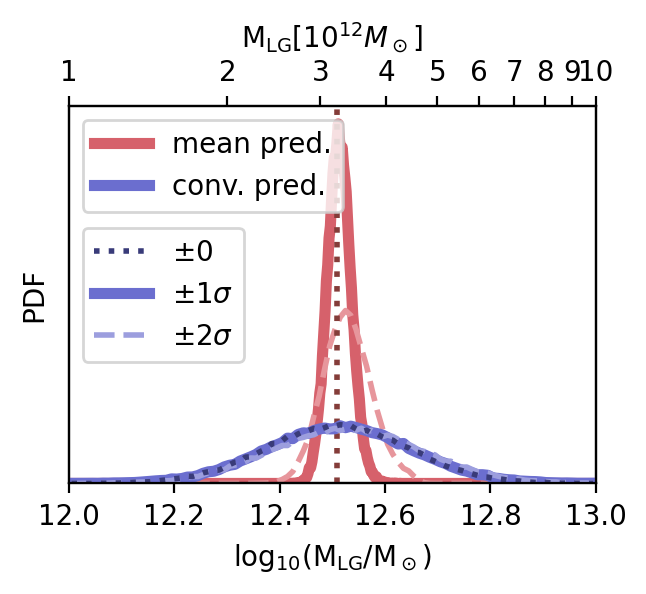

In [22]:
# Create a MC data set:

N_MC = int(1e5) # Note, we use 1e6 in the paper, but that requires > 32 GB of RAM.

sigma_colors = cm.tab20b

fig, ax = plt.subplots(figsize=(SingleColumn,2.5), ncols=1, nrows=1, dpi=dpi)

# 0 sigma:
r_MC = r_obs[0]
vr_MC = vr_obs[0]
vt_MC = vt_obs[0]

print ("median vt:", np.median(vt_MC))

X_MC = np.array([[r_MC], [vr_MC], [vt_MC]]).T

# scale the MC array
X_MC_scale = x_scaler.transform(X_MC)

# create prediction
print ("generating predictions")
mean_prediction_MC_scaled, std_prediction_MC_scaled = gaussian_process.predict(X_MC_scale, return_std=True)

# inverse scale the prediction
mean_prediction_MC = y_scaler.inverse_transform(mean_prediction_MC_scaled.reshape(-1, 1) )
mean_prediction_MC = np.array(mean_prediction_MC)
std_prediction_MC = std_prediction_MC_scaled * (b_minus_a)

print ("finished predictions for 0 sigma")

# direct prediction
samples = mean_prediction_MC

print ("prediction:", samples)

ax.axvline(samples, c=sigma_colors(12), lw=2, ls='dotted', label='mean pred.'+r'$\:\pm 0$', zorder=10)

# convolve the prediction with its Gaussian error:

# prediction
samples = np.random.normal(loc=mean_prediction_MC[0], scale=std_prediction_MC[0], size=N_MC)
h,e = np.histogram(samples, bins=100, density=True,  range = [12,13])
centers = (e[1:] + e[:-1])/2

low, med, high = np.percentile(10**samples, [16, 50, 84])
medstr = str(np.round( (med/1.e12), 2))
highstr = str(np.round( (high - med)/1.e12, 1))
lowstr = str(np.round( (med - low)/1.e12, 1))

text = r'$'+medstr+'^{+'+highstr+'}_{-'+lowstr+'}$'+r'$\times 10^{12} \mathrm{M_{\odot}}$'

print ("no error, convolved:", text)


ax.plot(centers, h, c=sigma_colors(0), lw=2, ls='dotted', label='convolved'+r'$\:\pm 0$', zorder=20)


# generate MC samples for 1 sigma
r_MC = np.random.normal(loc=r_obs[0], scale=r_obs[1], size=N_MC)
vr_MC = np.random.normal(loc=vr_obs[0], scale=vr_obs[1], size=N_MC)
vt_MC = np.random.normal(loc=vt_obs[0], scale=vt_obs[1], size=N_MC)

selection = np.where ( (vt_MC > 0) & (r_MC > 0) )

r_MC = r_MC[selection]
vr_MC = vr_MC[selection]
vt_MC = vt_MC[selection]

print ("median vt:", np.median(vt_MC))

X_MC = np.array([r_MC, vr_MC, vt_MC]).T

# scale the MC array
X_MC_scale = x_scaler.transform(X_MC)

# create prediction
print ("generating predictions")
mean_prediction_MC_scaled, std_prediction_MC_scaled = gaussian_process.predict(X_MC_scale, return_std=True)

# inverse scale the prediction
mean_prediction_MC = y_scaler.inverse_transform(mean_prediction_MC_scaled.reshape(-1, 1) )
mean_prediction_MC = np.array(mean_prediction_MC)
std_prediction_MC = std_prediction_MC_scaled * (b_minus_a)

print ("finished predictions for 1 sigma")

# direct prediction
samples = mean_prediction_MC

h,e = np.histogram(samples, bins=400, density=True,  range = [12,13])
centers = (e[1:] + e[:-1])/2

low, med, high = np.percentile(10**samples, [16, 50, 84])
medstr = str(np.round( (med/1.e12), 2))
highstr = str(np.round( (high - med)/1.e12, 1))
lowstr = str(np.round( (med - low)/1.e12, 1))

text = r'$'+medstr+'^{+'+highstr+'}_{-'+lowstr+'}$'+r'$\times 10^{12} \mathrm{M_{\odot}}$'

print ("1 sigma, mean:", text)

ax.plot(centers, h, c=sigma_colors(14), lw=4, ls='solid', label='mean pred.'+r'$\:\pm 1 \sigma$', zorder=2)

# convolve the prediction with its Gaussian error:

variables = []

for i in range (len(mean_prediction_MC)):
    variables.append( np.random.normal(loc=mean_prediction_MC[i], scale=std_prediction_MC[i]) )

# prediction
samples = np.array(variables)
h,e = np.histogram(samples, bins=100, density=True,  range = [12,13])
centers = (e[1:] + e[:-1])/2

low, med, high = np.percentile(10**samples, [16, 50, 84])
medstr = str(np.round( (med/1.e12), 2))
highstr = str(np.round( (high - med)/1.e12, 1))
lowstr = str(np.round( (med - low)/1.e12, 1))

text = r'$'+medstr+'^{+'+highstr+'}_{-'+lowstr+'}$'+r'$\times 10^{12} \mathrm{M_{\odot}}$'

print ("1 sigma, convolved:", text)


ax.plot(centers, h, c=sigma_colors(2), lw=4, ls='solid', label='conv.'+r'$\:\pm 1 \sigma$', zorder=12)



# 2 sigma


# generate MC samples for 2 sigma
r_MC = np.random.normal(loc=r_obs[0], scale=2*r_obs[1], size=N_MC)
vr_MC = np.random.normal(loc=vr_obs[0], scale=2*vr_obs[1], size=N_MC)
vt_MC = np.random.normal(loc=vt_obs[0], scale=2*vt_obs[1], size=N_MC)

selection = np.where ( (vt_MC > 0) & (r_MC > 0) )

r_MC = r_MC[selection]
vr_MC = vr_MC[selection]
vt_MC = vt_MC[selection]

print ("median vt:", np.median(vt_MC))

X_MC = np.array([r_MC, vr_MC, vt_MC]).T

# scale the MC array
X_MC_scale = x_scaler.transform(X_MC)

# create prediction
print ("generating predictions")
mean_prediction_MC_scaled, std_prediction_MC_scaled = gaussian_process.predict(X_MC_scale, return_std=True)

# inverse scale the prediction
mean_prediction_MC = y_scaler.inverse_transform(mean_prediction_MC_scaled.reshape(-1, 1) )
mean_prediction_MC = np.array(mean_prediction_MC)
std_prediction_MC = std_prediction_MC_scaled * (b_minus_a)

print ("finished predictions for 2 sigma")


# direct prediction
samples = mean_prediction_MC

h,e = np.histogram(samples, bins=100, density=True,  range = [12,13])
centers = (e[1:] + e[:-1])/2

low, med, high = np.percentile(10**samples, [16, 50, 84])
medstr = str(np.round( (med/1.e12), 2))
highstr = str(np.round( (high - med)/1.e12, 1))
lowstr = str(np.round( (med - low)/1.e12, 1))

text = r'$'+medstr+'^{+'+highstr+'}_{-'+lowstr+'}$'+r'$\times 10^{12} \mathrm{M_{\odot}}$'

print ("2 sigma, mean:", text)


ax.plot(centers, h, c=sigma_colors(15), lw=2, ls='dashed', label='mean '+r'$\:\pm 2 \sigma$', zorder=2)

# convolve the prediction with its Gaussian error:

variables = []

for i in range (len(mean_prediction_MC)):
    variables.append( np.random.normal(loc=mean_prediction_MC[i], scale=std_prediction_MC[i]) )

# prediction
samples = np.array(variables)
h,e = np.histogram(samples, bins=100, density=True,  range = [12,13])
centers = (e[1:] + e[:-1])/2

low, med, high = np.percentile(10**samples, [16, 50, 84])
medstr = str(np.round( (med/1.e12), 2))
highstr = str(np.round( (high - med)/1.e12, 1))
lowstr = str(np.round( (med - low)/1.e12, 1))

text = r'$'+medstr+'^{+'+highstr+'}_{-'+lowstr+'}$'+r'$\times 10^{12} \mathrm{M_{\odot}}$'

print ("2 sigma, convolved:", text)

ax.plot(centers, h, c=sigma_colors(3), lw=2, ls='dashed', label='convolved'+r'$\:\pm 2 \sigma$', zorder=15)


ax.set_xlim(12, 13)
ax.set_ylim(bottom=0)
ax.set_xlabel(r'$\mathrm{log_{10}(M_{LG} / M_\odot)}$')
ax.set_ylabel('PDF')
ax.set_yticks([])


ax2 = ax.twiny() # ax1 and ax2 share y-axis

ax2.set_xlabel(r'$\mathrm{M_{LG}} [10^{12} M_\odot]$')
ax2.set_xscale('log')
ax2.xaxis.set_major_formatter(ScalarFormatter())
ax2.ticklabel_format(style='plain')
ax2.set_xticks(np.arange(1,11))
ax2.set_xticklabels(map(str, np.arange(1,11)))
ax2.set_xlim(1,10)

# manual legends

lines = ax.get_lines()
legend1 = mpl.pyplot.legend([lines[i] for i in [1,3,5]], [r'$\pm 0$', r'$\pm 1 \sigma$', r'$\pm 2 \sigma$'], loc='center left', fontsize=10)
legend2 = mpl.pyplot.legend([lines[i] for i in [2,3]], ["mean pred.", "conv. pred."], loc='upper left', fontsize=10)

ax2.add_artist(legend1)

plt.savefig(plot_directory+'/Gaussian_regression_'+TrainingData+'_MC_predictions.pdf', bbox_inches='tight')


### 2D Distribution of kinematics, weighted by Gaussian distance _(Figure 11)_ <a id='2DKinematicsGaussian'></a> (back to [Contents](#Contents))

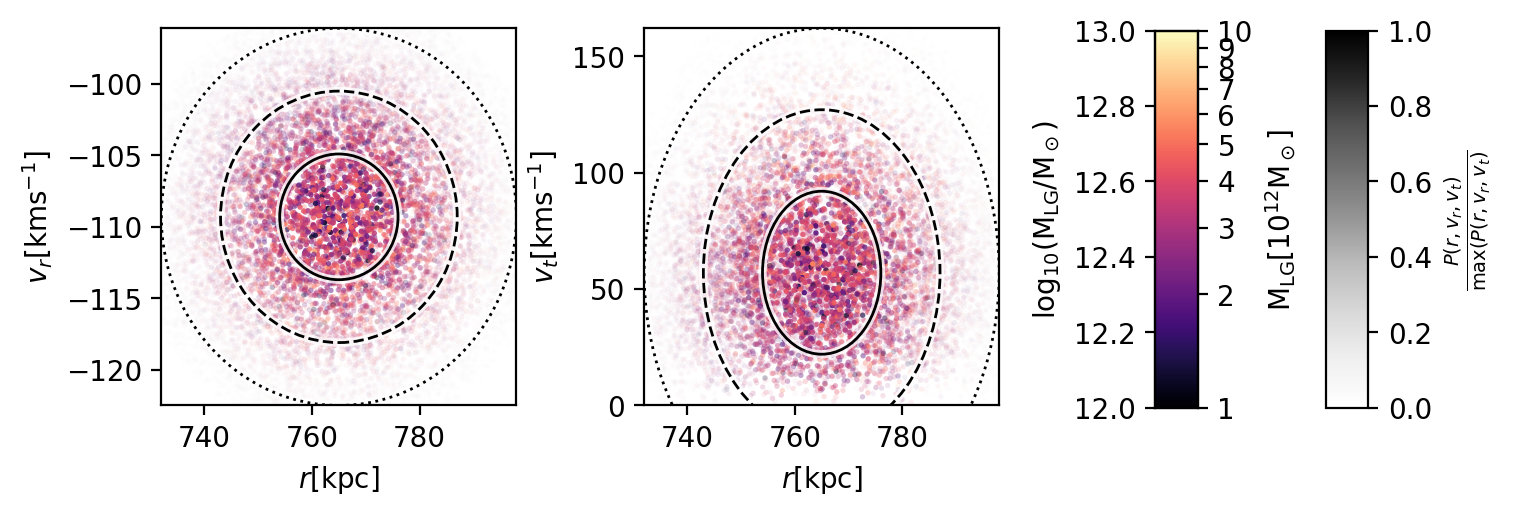

In [23]:
max_sigma = 3 

# Not including constraints on the MW, all LG analogues

selection = list ( set(c3_matches) & set(selection_true) ) 
fig, ax = plt.subplots(figsize=(DoubleColumn,2.3), ncols=4, nrows=1, dpi=dpi, gridspec_kw={'width_ratios': [10, 10, 1, 1]})

alphas = Gaussian_distance[selection] / np.max(Gaussian_distance[selection])

# vr vs. r

x = LG_r[selection]
y = LG_vr[selection]
c = cmap( norm(np.log10(LG_M_tot[selection]) ) )

im= ax[0].scatter(x, y, c=c, edgecolor='none', s=15., marker='.', alpha=alphas, rasterized="true")

ax[0].set_ylabel(r'$v_r \left[\mathrm{kms^{-1}}\right]$')
ax[0].set_xlabel(r'$r \left[\mathrm{kpc}\right]$')

ax[0].set_xlim(r_obs[0] - max_sigma* r_obs[1], r_obs[0] + max_sigma* r_obs[1])
ax[0].set_ylim(vr_obs[0] - max_sigma* vr_obs[1], vr_obs[0] + max_sigma* vr_obs[1])

# error ellipse
el = mpatches.Ellipse((r_obs[0], vr_obs[0] ), r_obs[1]*2, vr_obs[1]*2,  edgecolor='white', alpha=.8, facecolor='none', lw=3, ls='solid')
ax[0].add_artist(el)
el = mpatches.Ellipse((r_obs[0], vr_obs[0] ), r_obs[1]*2*2, vr_obs[1]*2*2,  edgecolor='white', alpha=.8, facecolor='none', lw=3, ls='solid')
ax[0].add_artist(el)
el = mpatches.Ellipse((r_obs[0], vr_obs[0] ), r_obs[1]*3*2, vr_obs[1]*3*2,  edgecolor='white', alpha=.8, facecolor='none', lw=3, ls='solid')
ax[0].add_artist(el)
el = mpatches.Ellipse((r_obs[0], vr_obs[0] ), r_obs[1]*2, vr_obs[1]*2,  edgecolor='black', facecolor='none', lw=1, ls='solid')
ax[0].add_artist(el)
el = mpatches.Ellipse((r_obs[0], vr_obs[0] ), r_obs[1]*2*2, vr_obs[1]*2*2,  edgecolor='black', facecolor='none', lw=1, ls='dashed')
ax[0].add_artist(el)
el = mpatches.Ellipse((r_obs[0], vr_obs[0] ), r_obs[1]*3*2, vr_obs[1]*3*2,  edgecolor='black', facecolor='none', lw=1, ls='dotted')
ax[0].add_artist(el)


# vt vs. r

x = LG_r[selection]
y = LG_vt[selection]

im= ax[1].scatter(x, y, c=c, edgecolor='none', s=15., marker='.', alpha=alphas, rasterized="true")
ax[1].set_ylabel(r'$v_t \left[\mathrm{kms^{-1}}\right]$')
ax[1].set_xlabel(r'$r \left[\mathrm{kpc}\right]$')
ax[1].set_xlim(r_obs[0] - max_sigma* r_obs[1], r_obs[0] + max_sigma* r_obs[1])
ax[1].set_ylim(0, vt_obs[0] + max_sigma* vt_obs[1])

# error ellipse
el = mpatches.Ellipse((r_obs[0], vt_obs[0] ), r_obs[1]*2, vt_obs[1]*2,  edgecolor='white', alpha=.8, facecolor='none', lw=3, ls='solid')
ax[1].add_artist(el)
el = mpatches.Ellipse((r_obs[0], vt_obs[0] ), r_obs[1]*2*2, vt_obs[1]*2*2,  edgecolor='white', alpha=.8, facecolor='none', lw=3, ls='solid')
ax[1].add_artist(el)
el = mpatches.Ellipse((r_obs[0], vt_obs[0] ), r_obs[1]*3*2, vt_obs[1]*3*2,  edgecolor='white', alpha=.8, facecolor='none', lw=3, ls='solid')
ax[1].add_artist(el)
el = mpatches.Ellipse((r_obs[0], vt_obs[0] ), r_obs[1]*2, vt_obs[1]*2,  edgecolor='black', facecolor='none', lw=1, ls='solid')
ax[1].add_artist(el)
el = mpatches.Ellipse((r_obs[0], vt_obs[0] ), r_obs[1]*2*2, vt_obs[1]*2*2,  edgecolor='black', facecolor='none', lw=1, ls='dashed')
ax[1].add_artist(el)
el = mpatches.Ellipse((r_obs[0], vt_obs[0] ), r_obs[1]*3*2, vt_obs[1]*3*2,  edgecolor='black', facecolor='none', lw=1, ls='dotted')
ax[1].add_artist(el)


# color bars

# hue colour bar

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax[2])
ax[2].set_ylabel(r'$\mathrm{log_{10}\left(M_{LG}/M_\odot\right)}$')
ax[2].yaxis.set_label_position("left")

ax2 = ax[2].twinx() # ax1 and ax2 share x-axis
ax2.set_ylabel(r'$\mathrm{M_{LG}} [10^{12} \mathrm{M_\odot}]$')
ax2.set_yscale('log')
ax2.yaxis.set_major_formatter(ScalarFormatter())
ax2.ticklabel_format(style='plain')
ax2.set_yticks(np.arange(1,11))
ax2.set_yticklabels(map(str, np.arange(1,11)))
ax2.set_ylim(1,10)
ax2.yaxis.set_label_position("right")

# alpha colour bar

cmap1 = mpl.cm.Greys
norm1 = mpl.colors.Normalize(vmin=0, vmax=1)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm1, cmap=cmap1), cax=ax[3])
ax[3].set_ylabel(r'$\frac{P(r, v_r, v_t)}{\mathrm{max}(P(r, v_r, v_t)}$')

ax[0].set_position([0.08,0.155, 0.25, 0.82])
ax[1].set_position([0.42,0.155, 0.25, 0.82])
ax[2].set_position([0.78,0.15, 0.03, 0.82])
ax[3].set_position([0.9,0.15, 0.03, 0.82])

plt.savefig(plot_directory+'/uchuu_r_vr_vt_tidal_gaussian.pdf', bbox_inches='tight')


### Histograms of r, vr and vt, weighted by Gaussian Distance, and overplotting the observations _(Figure 12)_ <a id='HistogramsGaussianObs'></a> (back to [Contents](#Contents))

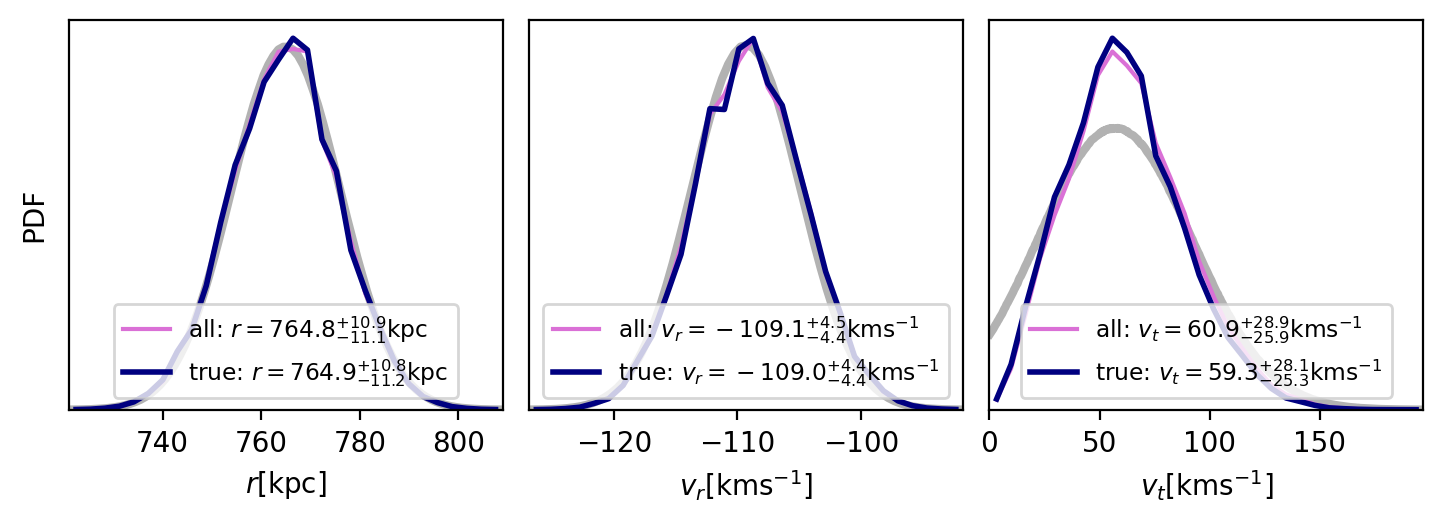

In [24]:
fig, ax = plt.subplots(figsize=(DoubleColumn,2.5), ncols=3, nrows=1, dpi=dpi, constrained_layout = True)

# r

min_x = r_obs[0]-r_obs[1]*4
max_x = r_obs[0]+r_obs[1]*4


# weighted histogram (all)
selection = selection_all
samples = LG_r[selection]
weights = Gaussian_distance[selection]
h,e = np.histogram(samples, weights = weights, bins=30, density=True, range=(min_x,max_x))
centers = (e[1:] + e[:-1])/2

low, med, high = weighted_quantile(samples, [0.1586, 0.50, 0.8414], sample_weight=weights)
medstr = f'{med:.1f}'
highstr = f'{high - med:.1f}'
lowstr = f'{low - med:.1f}'
text = r'all: $r='+medstr+'^{+'+highstr+'}_{'+lowstr+'}$'+'kpc'
ax[0].plot(centers, h, c='orchid', lw=1.5, label=text, zorder=2)

# weighted histogram (subset)
selection = selection_true
samples = LG_r[selection]
weights = Gaussian_distance[selection]
h,e = np.histogram(samples, weights = weights, bins=30, density=True, range=(min_x,max_x))
centers = (e[1:] + e[:-1])/2

low, med, high = weighted_quantile(samples, [0.1586, 0.50, 0.8414], sample_weight=weights)
medstr = f'{med:.1f}'
highstr = f'{high - med:.1f}'
lowstr = f'{low - med:.1f}'
text = r'true: $r='+medstr+'^{+'+highstr+'}_{'+lowstr+'}$'+'kpc'

ax[0].plot(centers, h, c='navy', lw=2, label=text, zorder=2)
ax[0].set_xlim(min_x, max_x)
ax[0].set_xlabel(r'$r$[kpc]')
ax[0].set_ylabel('PDF')
ax[0].set_yticks([])
ax[0].set_ylim(bottom=0)
ax[0].legend(loc='lower center', fontsize=8.4)

# vr

min_x = vr_obs[0]-vr_obs[1]*4
max_x = vr_obs[0]+vr_obs[1]*4

# weighted histogram (all)
selection = selection_all
samples = LG_vr[selection]
weights = Gaussian_distance[selection]
h,e = np.histogram(samples, weights = weights, bins=30, density=True, range=(min_x,max_x))
centers = (e[1:] + e[:-1])/2

low, med, high = weighted_quantile(samples, [0.1586, 0.50, 0.8414], sample_weight=weights)
medstr = f'{med:.1f}'
highstr = f'{high - med:.1f}'
lowstr = f'{low - med:.1f}'
text = r'all: $v_r='+medstr+'^{+'+highstr+'}_{'+lowstr+'}$'+'kms$^{-1}$'

#ax[1].axvline(med, color='orchid', lw=1.5)
ax[1].plot(centers, h, c='orchid', lw=1.5, label=text, zorder=2)

# weighted histogram (subset)
selection = selection_true
samples = LG_vr[selection]
weights = Gaussian_distance[selection]
h,e = np.histogram(samples, weights = weights, bins=30, density=True, range=(min_x,max_x))
centers = (e[1:] + e[:-1])/2

low, med, high = weighted_quantile(samples, [0.1586, 0.50, 0.8414], sample_weight=weights)
medstr = f'{med:.1f}'
highstr = f'{high - med:.1f}'
lowstr = f'{low - med:.1f}'
text = r'true: $v_r='+medstr+'^{+'+highstr+'}_{'+lowstr+'}$'+'kms$^{-1}$'

ax[0].axvline(med, color='navy', lw=2)

ax[1].plot(centers, h, c='navy', lw=2, label=text, zorder=2)
ax[1].set_xlim(min_x, max_x)
ax[1].set_xlabel(r'$v_r$[kms$^{-1}$]')
ax[1].set_yticks([])
ax[1].set_ylim(bottom=0)
ax[1].legend(loc='lower center', fontsize=8.4)


# vt

min_x = 0
max_x = vt_obs[0]+vt_obs[1]*4


# weighted histogram (all)
selection = selection_all
samples = LG_vt[selection]
weights = Gaussian_distance[selection]
h,e = np.histogram(samples, weights = weights, bins=30, density=True, range=(min_x,max_x))
centers = (e[1:] + e[:-1])/2

low, med, high = weighted_quantile(samples, [0.1586, 0.50, 0.8414], sample_weight=weights)
medstr = f'{med:.1f}'
highstr = f'{high - med:.1f}'
lowstr = f'{low - med:.1f}'
text = r'all: $v_t='+medstr+'^{+'+highstr+'}_{'+lowstr+'}$'+'kms$^{-1}$'

ax[2].plot(centers, h, c='orchid', lw=1.5, label=text, zorder=2)

# weighted histogram (subset)
selection = selection_true
samples = LG_vt[selection]
weights = Gaussian_distance[selection]
h,e = np.histogram(samples, weights = weights, bins=30, density=True, range=(min_x,max_x))
centers = (e[1:] + e[:-1])/2

low, med, high = weighted_quantile(samples, [0.1586, 0.50, 0.8414], sample_weight=weights)
medstr = f'{med:.1f}'
highstr = f'{high - med:.1f}'
lowstr = f'{low - med:.1f}'
text = r'true: $v_t='+medstr+'^{+'+highstr+'}_{'+lowstr+'}$'+'kms$^{-1}$'


ax[2].plot(centers, h, c='navy', lw=2, label=text, zorder=2)
ax[2].set_xlim(min_x, max_x)
ax[2].set_xlabel(r'$v_t$[kms$^{-1}$]')
ax[2].set_yticks([])
ax[2].set_ylim(bottom=0)
ax[2].legend(loc='lower center', fontsize=8.4)

# overplot MC samples

N_MC = int(1e8)

r_MC = np.random.normal(loc=r_obs[0], scale=r_obs[1], size=N_MC)
vr_MC = np.random.normal(loc=vr_obs[0], scale=vr_obs[1], size=N_MC)
vt_MC = np.random.normal(loc=vt_obs[0], scale=vt_obs[1], size=N_MC)

selection = np.where(vt_MC > 0)

samples = r_MC[selection]
h,e = np.histogram(samples, bins=500, density=True,  range=(500,1000))
centers = (e[1:] + e[:-1])/2
ax[0].plot(centers, h, c='black', alpha=.3, lw=3, label=text, zorder=0 )

samples = vr_MC[selection]
h,e = np.histogram(samples, bins=500, density=True,  range=(-250,0))
centers = (e[1:] + e[:-1])/2
ax[1].plot(centers, h, c='black', alpha=.3, lw=3, label=text, zorder=0 )

samples = vt_MC[selection]
h,e = np.histogram(samples, bins=500, density=True,  range=(0,250))
centers = (e[1:] + e[:-1])/2
ax[2].plot(centers, h, c='black', alpha=.3, lw=3, label=text, zorder=0 )


plt.savefig(plot_directory+'/uchuu_features_histogram_gaussian.pdf', bbox_inches='tight')


### Histograms of total mass, M1 mass, M2 mass and mass ratio, weighted by Gaussian Distance _(Figure 13)_  <a id='MassHistogramsGaussian'></a> (back to [Contents](#Contents))

med mass ratio: 1.841704599406803
medstr: 2.29


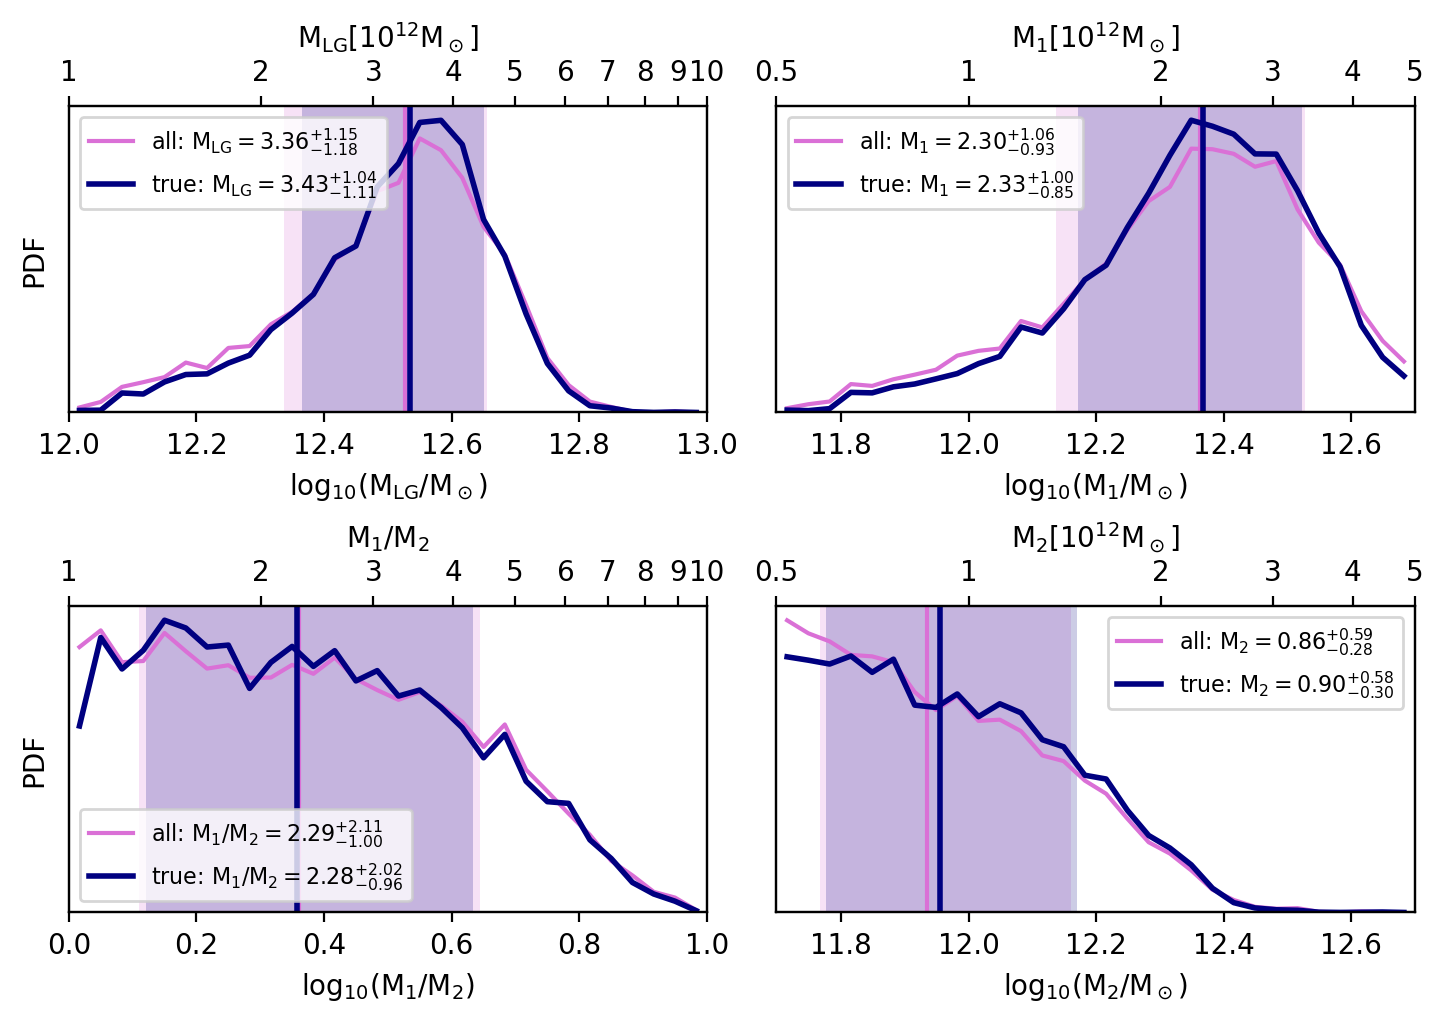

In [25]:
fig, ax = plt.subplots(figsize=(DoubleColumn,5), ncols=2, nrows=2, dpi=dpi, constrained_layout = True)

min_x = 12
max_x = 13

# weighted histogram (all)
selection = selection_all
samples = np.log10(LG_M_tot[selection])
weights = Gaussian_distance[selection]
h,e = np.histogram(samples, weights = weights, bins=30, density=True, range=(min_x,max_x))
centers = (e[1:] + e[:-1])/2

low, med, high = weighted_quantile(samples, [0.1586, 0.50, 0.8414], sample_weight=weights)
medstr = f'{10**(med) / 1.e12:.2f}'
highstr = f'{(10**(high) - 10**(med)) / 1.e12:.2f}'
lowstr = f'{(10**(low) - 10**(med)) / 1.e12:.2f}'
text = r'all: $\mathrm{M_{LG}}='+medstr+'^{+'+highstr+'}_{'+lowstr+'}$'

ax[0,0].axvline(med, color='orchid', lw=1.5)
ax[0,0].axvspan(low,high,  facecolor='orchid', alpha=0.2)
ax[0,0].plot(centers, h, c='orchid', lw=1.5, label=text, zorder=2)

# weighted histogram (subset)
selection = selection_true
samples = np.log10(LG_M_tot[selection])
weights = Gaussian_distance[selection]
h,e = np.histogram(samples, weights = weights, bins=30, density=True, range=(min_x,max_x))
centers = (e[1:] + e[:-1])/2

low, med, high = weighted_quantile(samples, [0.1586, 0.50, 0.8414], sample_weight=weights)
medstr = f'{10**(med) / 1.e12:.2f}'
highstr = f'{(10**(high) - 10**(med)) / 1.e12:.2f}'
lowstr = f'{(10**(low) - 10**(med)) / 1.e12:.2f}'
text = r'true: $\mathrm{M_{LG}}='+medstr+'^{+'+highstr+'}_{'+lowstr+'}$'

ax[0,0].axvline(med, color='navy', lw=2)
ax[0,0].axvspan(low,high,  facecolor='navy', alpha=0.2)
ax[0,0].plot(centers, h, c='navy', lw=2, label=text, zorder=2)
ax[0,0].set_xlim(min_x, max_x)

ax2 = ax[0,0].twiny() # ax1 and ax2 share y-axis
ax2.set_xscale('log')
ax2.xaxis.set_major_formatter(ScalarFormatter())
ax2.ticklabel_format(style='plain')
ax2.set_xticks([1, 2, 3, 4, 5, 6, 7, 8,9,10])
ax2.set_xticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
ax2.set_xlim(1,10)

ax2.set_xlabel(r'$\mathrm{M_{LG} [10^{12} M_\odot]}$')

ax[0,0].set_xlabel(r'$\mathrm{log_{10}\left(M_{LG}/M_\odot\right)}$')
ax[0,0].set_ylabel('PDF')
ax[0,0].set_yticks([])
ax[0,0].set_ylim(bottom=0)
ax[0,0].legend(loc='upper left', fontsize=8.)


# M1 Mass

min_x = np.log10(5.e11)
max_x = np.log10(5.e12)

# weighted histogram (all)
selection = selection_all
samples = np.log10(LG_M_M31[selection])
weights = Gaussian_distance[selection]
h,e = np.histogram(samples, weights = weights, bins=30, density=True, range=(min_x,max_x))
centers = (e[1:] + e[:-1])/2

low, med, high = weighted_quantile(samples, [0.1586, 0.50, 0.8414], sample_weight=weights)
medstr = f'{10**(med) / 1.e12:.2f}'
highstr = f'{(10**(high) - 10**(med)) / 1.e12:.2f}'
lowstr = f'{(10**(low) - 10**(med)) / 1.e12:.2f}'
text = r'all: $\mathrm{M_{1}}='+medstr+'^{+'+highstr+'}_{'+lowstr+'}$'

ax[0,1].axvline(med, color='orchid', lw=1.5)
ax[0,1].axvspan(low,high,  facecolor='orchid', alpha=0.2)
ax[0,1].plot(centers, h, c='orchid', lw=1.5, label=text, zorder=2)

# weighted histogram (subset)
selection = selection_true
samples = np.log10(LG_M_M31[selection])
weights = Gaussian_distance[selection]
h,e = np.histogram(samples, weights = weights, bins=30, density=True, range=(min_x,max_x))
centers = (e[1:] + e[:-1])/2

low, med, high = weighted_quantile(samples, [0.1586, 0.50, 0.8414], sample_weight=weights)
medstr = f'{10**(med) / 1.e12:.2f}'
highstr = f'{(10**(high) - 10**(med)) / 1.e12:.2f}'
lowstr = f'{(10**(low) - 10**(med)) / 1.e12:.2f}'
text = r'true: $\mathrm{M_{1}}='+medstr+'^{+'+highstr+'}_{'+lowstr+'}$'

ax[0,1].axvline(med, color='navy', lw=2)
ax[0,1].axvspan(low,high,  facecolor='navy', alpha=0.2)
ax[0,1].plot(centers, h, c='navy', lw=2, label=text, zorder=2)
ax[0,1].set_xlim(min_x, max_x)

ax2 = ax[0,1].twiny() # ax1 and ax2 share y-axis
ax2.set_xscale('log')
ax2.xaxis.set_major_formatter(ScalarFormatter())
ax2.ticklabel_format(style='plain')
ax2.set_xticks([0.5, 1, 2, 3, 4, 5])
ax2.set_xticklabels(['0.5', '1', '2', '3', '4', '5'])
ax2.set_xlim(0.5,5)
ax2.minorticks_off()
ax2.set_xlabel(r'$\mathrm{M_{1} [10^{12} M_\odot]}$')

ax[0,1].set_xlabel(r'$\mathrm{log_{10}\left(M_{1}/M_\odot\right)}$')
ax[0,1].set_yticks([])
ax[0,1].set_ylim(bottom=0)
ax[0,1].legend(loc='upper left', fontsize=8.)


# M2 Mass

min_x = np.log10(5.e11)
max_x = np.log10(5.e12)

# weighted histogram (all)
selection = selection_all
samples = np.log10(LG_M_MW[selection])
weights = Gaussian_distance[selection]
h,e = np.histogram(samples, weights = weights, bins=30, density=True, range=(min_x,max_x))
centers = (e[1:] + e[:-1])/2

low, med, high = weighted_quantile(samples, [0.1586, 0.50, 0.8414], sample_weight=weights)
medstr = f'{10**(med) / 1.e12:.2f}'
highstr = f'{(10**(high) - 10**(med)) / 1.e12:.2f}'
lowstr = f'{(10**(low) - 10**(med)) / 1.e12:.2f}'
text = r'all: $\mathrm{M_{2}}='+medstr+'^{+'+highstr+'}_{'+lowstr+'}$'

ax[1,1].axvline(med, color='orchid', lw=1.5)
ax[1,1].axvspan(low,high,  facecolor='orchid', alpha=0.2)
ax[1,1].plot(centers, h, c='orchid', lw=1.5, label=text, zorder=2)

# weighted histogram (subset)
selection = selection_true
samples = np.log10(LG_M_MW[selection])
weights = Gaussian_distance[selection]
h,e = np.histogram(samples, weights = weights, bins=30, density=True, range=(min_x,max_x))
centers = (e[1:] + e[:-1])/2

low, med, high = weighted_quantile(samples, [0.1586, 0.50, 0.8414], sample_weight=weights)
medstr = f'{10**(med) / 1.e12:.2f}'
highstr = f'{(10**(high) - 10**(med)) / 1.e12:.2f}'
lowstr = f'{(10**(low) - 10**(med)) / 1.e12:.2f}'

text = r'true: $\mathrm{M_{2}}='+medstr+'^{+'+highstr+'}_{'+lowstr+'}$'

ax[1,1].axvline(med, color='navy', lw=2)
ax[1,1].axvspan(low,high,  facecolor='navy', alpha=0.2)
ax[1,1].plot(centers, h, c='navy', lw=2, label=text, zorder=2)
ax[1,1].set_xlim(min_x, max_x)

ax2 = ax[1,1].twiny() # ax1 and ax2 share y-axis
ax2.set_xscale('log')
ax2.xaxis.set_major_formatter(ScalarFormatter())
ax2.ticklabel_format(style='plain')
ax2.set_xticks([0.5, 1, 2, 3, 4, 5])
ax2.set_xticklabels(['0.5', '1', '2', '3', '4', '5'])
ax2.set_xlim(0.5,5)
ax2.minorticks_off()
ax2.set_xlabel(r'$\mathrm{M_{2} [10^{12} M_\odot]}$')

ax[1,1].set_xlabel(r'$\mathrm{log_{10}\left(M_{2}/M_\odot\right)}$')
ax[1,1].set_yticks([])
ax[1,1].set_ylim(bottom=0)
ax[1,1].legend(loc='upper right', fontsize=8.)



# Massratio

min_x = 0
max_x = 1

# weighted histogram (all)
selection = selection_all
samples = np.log10(LG_M_M31[selection] / LG_M_MW[selection])
weights = Gaussian_distance[selection]
h,e = np.histogram(samples, weights = weights, bins=30, density=True, range=(min_x,max_x))
centers = (e[1:] + e[:-1])/2

low, med, high = weighted_quantile(samples, [0.1586, 0.50, 0.8414], sample_weight=weights)
medstr = f'{10**(med):.2f}'
highstr = f'{10**(high) - 10**(med):.2f}'
lowstr = f'{10**(low) - 10**(med):.2f}'
text = r'all: $\mathrm{M_1/M_2}='+medstr+'^{+'+highstr+'}_{'+lowstr+'}$'

print ("med mass ratio:", np.median(LG_M_M31[selection] / LG_M_MW[selection]) )
print ("medstr:", medstr)

ax[1,0].axvline(med, color='orchid', lw=1.5)
ax[1,0].axvspan(low,high,  facecolor='orchid', alpha=0.2)
ax[1,0].plot(centers, h, c='orchid', lw=1.5, label=text, zorder=2)


# weighted histogram (subset)
selection = selection_true
samples = np.log10(LG_M_M31[selection] / LG_M_MW[selection])
weights = Gaussian_distance[selection]
h,e = np.histogram(samples, weights = weights, bins=30, density=True, range=(min_x,max_x))
centers = (e[1:] + e[:-1])/2

low, med, high = weighted_quantile(samples, [0.1586, 0.50, 0.8414], sample_weight=weights)
medstr = f'{10**(med):.2f}'
highstr = f'{10**(high) - 10**(med):.2f}'
lowstr = f'{10**(low) - 10**(med):.2f}'
text = r'true: $\mathrm{M_1/M_2}='+medstr+'^{+'+highstr+'}_{'+lowstr+'}$'

ax[1,0].axvline(med, color='navy', lw=2)
ax[1,0].axvspan(low,high,  facecolor='navy', alpha=0.2)
ax[1,0].plot(centers, h, c='navy', lw=2, label=text, zorder=2)
ax[1,0].set_xlim(min_x, max_x)

ax2 = ax[1,0].twiny() # ax1 and ax2 share y-axis
ax2.set_xscale('log')
ax2.xaxis.set_major_formatter(ScalarFormatter())
ax2.ticklabel_format(style='plain')
ax2.set_xticks([1, 2, 3, 4, 5, 6, 7, 8,9,10])
ax2.set_xticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
ax2.set_xlim(1,10)
ax2.set_xlabel(r'$\mathrm{M_{1} / M_{2}}$')

ax[1,0].set_xlabel(r'$\mathrm{log_{10}\left(M_{1} / M_{2}\right)}$')
ax[1,0].set_ylabel('PDF')
ax[1,0].set_yticks([])
ax[1,0].set_ylim(bottom=0)
ax[1,0].legend(loc='lower left', fontsize=8.)

plt.savefig(plot_directory+'/uchuu_covariants_histogram_gaussian.pdf', bbox_inches='tight')

### Histograms of probability-weighted masses and of TA predicted masses _(Figure 14)_  <a id='PlotTAcomparison'></a> (back to [Contents](#Contents))

/tmp/ipykernel_2655233/824741715.py:21: RuntimeWarning: divide by zero encountered in log10
  samples = np.log10(LG_M_TA[selection])
/tmp/ipykernel_2655233/824741715.py:27: RuntimeWarning: divide by zero encountered in log10
  samples = np.log10(LG_M_TA[selection])


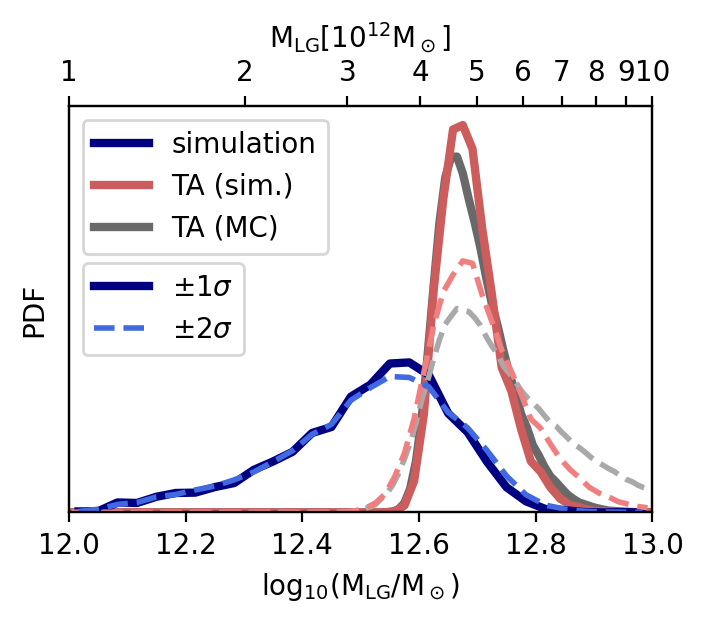

In [26]:
fig, ax = plt.subplots(figsize=(SingleColumn, 3.), dpi=dpi, constrained_layout = True)

# weighted histograms

# simulation
selection = selection_true

samples = np.log10(LG_M_tot[selection])
weights = Gaussian_distance[selection]
h,e = np.histogram(samples, weights = weights, bins=30, density=True, range=(12,13))
centers = (e[1:] + e[:-1])/2
ax.plot(centers, h, c='navy', lw=3, ls='solid', alpha=1., zorder=10)

samples = np.log10(LG_M_tot[selection])
weights = Gaussian_distance_2sigma[selection]
h,e = np.histogram(samples, weights = weights, bins=30, density=True, range=(12,13))
centers = (e[1:] + e[:-1])/2
ax.plot(centers, h, c='royalblue', lw=2, ls='dashed', alpha=1., zorder=15)

# TA (simulation)
samples = np.log10(LG_M_TA[selection])
weights = Gaussian_distance[selection]
h,e = np.histogram(samples, weights = weights, bins=60, density=True, range=(12,13))
centers = (e[1:] + e[:-1])/2
ax.plot(centers, h, c='indianred', lw=3, ls='solid', alpha=1., zorder=2)

samples = np.log10(LG_M_TA[selection])
weights = Gaussian_distance_2sigma[selection]
h,e = np.histogram(samples, weights = weights, bins=60, density=True, range=(12,13))
centers = (e[1:] + e[:-1])/2
ax.plot(centers, h, c='lightcoral', lw=2, ls='dashed', alpha=1., zorder=14)

# TA (MC)
selection = np.where (LG_M_TA_MC_1sigma > 0.)
samples = np.log10(LG_M_TA_MC_1sigma[selection])
h,e = np.histogram(samples, bins=100, density=True, range=(12,13))
centers = (e[1:] + e[:-1])/2
ax.plot(centers, h, c='dimgrey', lw=3, ls='solid', alpha=1., zorder=1)

selection = np.where (LG_M_TA_MC_2sigma > 0.)
samples =  np.log10(LG_M_TA_MC_2sigma[selection])
h,e = np.histogram(samples, bins=100, density=True,range=(12,13))
centers = (e[1:] + e[:-1])/2
ax.plot(centers, h, c='darkgrey', lw=2, ls='dashed', alpha=1., zorder=12)

ax.set_xlim(12,13)
ax.set_ylim(bottom=0)
ax.set_xlabel(r'$\mathrm{log_{10}(M_{LG} / \mathrm{M}_\odot)}$')
ax.set_ylabel('PDF')
ax.set_yticks([])

ax2 = ax.twiny() # ax1 and ax2 share y-axis
ax2.set_xlabel(r'$\mathrm{M_{LG}} [10^{12} \mathrm{M}_\odot]$')
ax2.set_xscale('log')
ax2.xaxis.set_major_formatter(ScalarFormatter())
ax2.ticklabel_format(style='plain')
ax2.set_xticks(np.arange(1,11))
ax2.set_xticklabels(map(str, np.arange(1,11)))
ax2.set_xlim(1,10)

# manual legends

lines = ax.get_lines()
legend1 = mpl.pyplot.legend([lines[i] for i in [0,1]], [r'$\pm 1 \sigma$', r'$\pm 2 \sigma$'], loc='center left', fontsize=10)
legend2 = mpl.pyplot.legend([lines[i] for i in [0,2,4]], ["simulation", "TA (sim.)", "TA (MC)"], loc='upper left', fontsize=10)

ax2.add_artist(legend1)

plt.savefig(plot_directory+'/mass_TA_histograms.pdf')

### Histograms of Total mass, MW mass, M31 mass and mass ratio, weighted by Gaussian Distance, including the mass of the MW _(Figure 15)_ <a id='MassHistogramsGaussianMW'></a> (back to [Contents](#Contents))

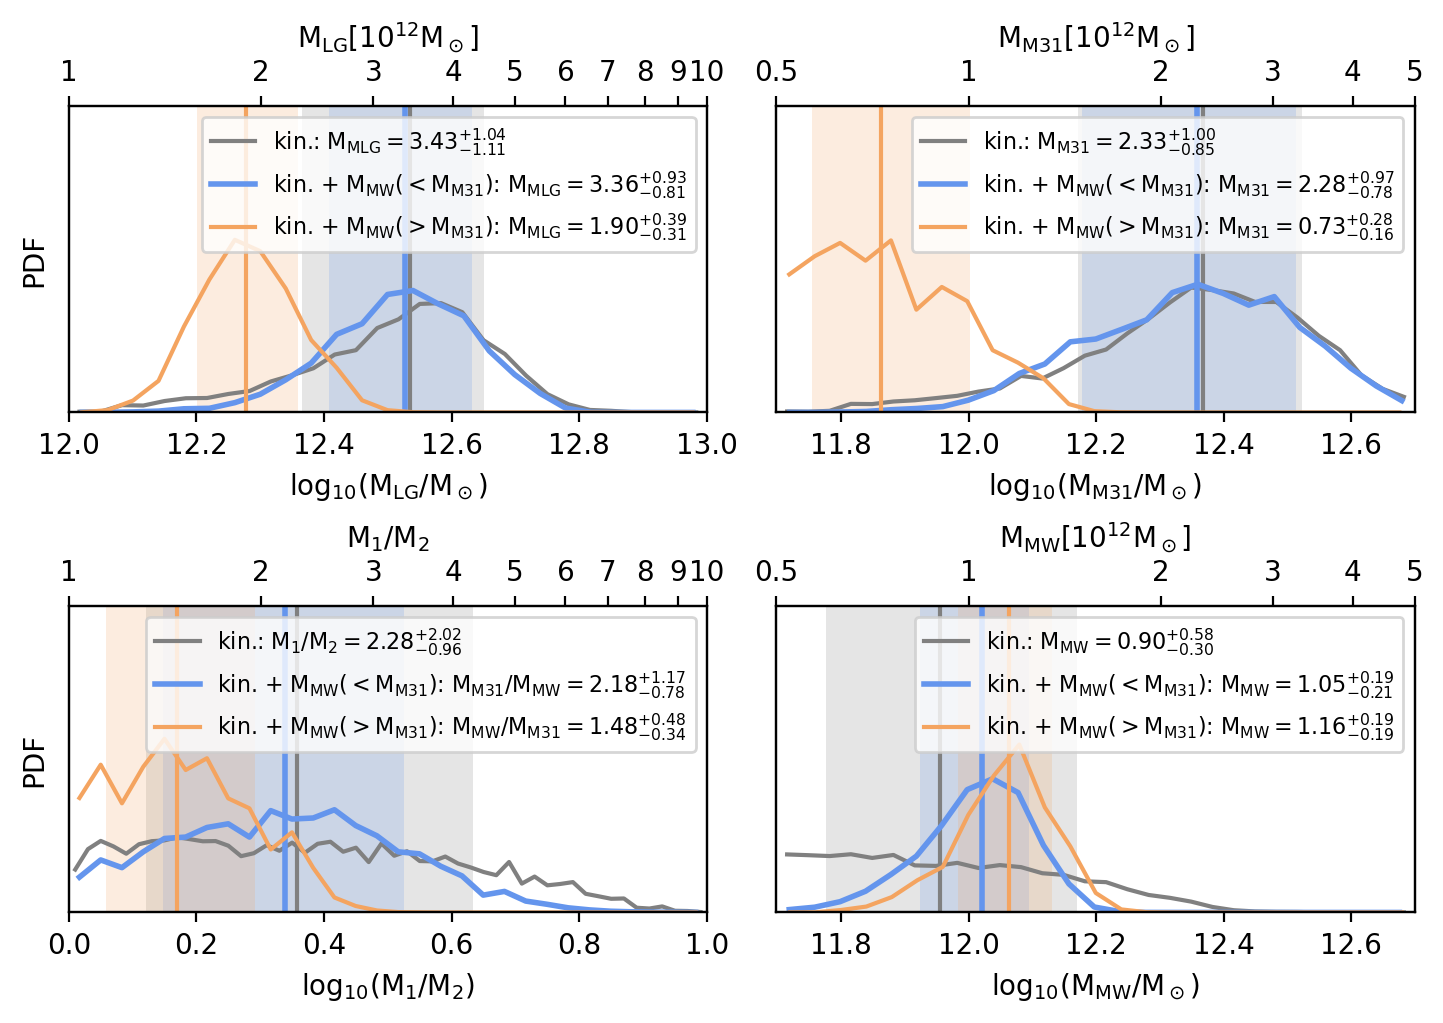

In [27]:
fig, ax = plt.subplots(figsize=(DoubleColumn,5), ncols=2, nrows=2, dpi=dpi, constrained_layout = True)

# we use this selection as the default
selection = selection_true

# Total Mass
samples = np.log10(LG_M_tot[selection])
min_x = 12
max_x = 13

# pure kinematics weighted histogram
weights = Gaussian_distance[selection]
h,e = np.histogram(samples, weights = weights, bins=30, density=True, range=(min_x,max_x))
centers = (e[1:] + e[:-1])/2

low, med, high = weighted_quantile(samples, [0.1586, 0.50, 0.8414], sample_weight=weights)
medstr = f'{10**(med) / 1.e12:.2f}'
highstr = f'{(10**(high) - 10**(med))/1.e12:.2f}'
lowstr = f'{(10**(low) - 10**(med))/1.e12:.2f}'
text = r'$\mathrm{M_{MLG}}='+medstr+'^{+'+highstr+'}_{'+lowstr+'}$'

ax[0,0].axvline(med, color='grey', lw=1.5)
ax[0,0].axvspan(low,high,  facecolor='grey', alpha=0.2)
ax[0,0].plot(centers, h, c='grey', lw=1.5, label=r'kin.: '+text, zorder=2)

# MW weighted histogram (regular)
weights = Gaussian_distance_MW[selection]
h,e = np.histogram(samples, weights = weights, bins=25, density=True)
centers = (e[1:] + e[:-1])/2

low, med, high = weighted_quantile(samples, [0.1586, 0.50, 0.8414], sample_weight=weights)
medstr = f'{10**(med) / 1.e12:.2f}'
highstr = f'{(10**(high) - 10**(med))/1.e12:.2f}'
lowstr = f'{(10**(low) - 10**(med))/1.e12:.2f}'
text = r'$\mathrm{M_{MLG}}='+medstr+'^{+'+highstr+'}_{'+lowstr+'}$'

ax[0,0].axvline(med, color='cornflowerblue', lw=2.)
ax[0,0].axvspan(low,high,  facecolor='cornflowerblue', alpha=0.2)
ax[0,0].plot(centers, h, c='cornflowerblue', lw=2., label=r'kin. + $\mathrm{M_{MW} (< M_{M31})}$: '+text, zorder=2)

# MW weighted histogram (inverted)
weights = Gaussian_distance_MW_invert[selection]
h,e = np.histogram(samples, weights = weights, bins=25, density=True)
centers = (e[1:] + e[:-1])/2

low, med, high = weighted_quantile(samples, [0.1586, 0.50, 0.8414], sample_weight=weights)
medstr = f'{10**(med) / 1.e12:.2f}'
highstr = f'{(10**(high) - 10**(med))/1.e12:.2f}'
lowstr = f'{(10**(low) - 10**(med))/1.e12:.2f}'
text = r'$\mathrm{M_{MLG}}='+medstr+'^{+'+highstr+'}_{'+lowstr+'}$'

ax[0,0].axvline(med, color='sandybrown', lw=1.5)
ax[0,0].axvspan(low,high,  facecolor='sandybrown', alpha=0.2)
ax[0,0].plot(centers, h, c='sandybrown', lw=1.5, label=r'kin. + $\mathrm{M_{MW} (> M_{M31})}$: '+text, zorder=2)

ax[0,0].set_xlim(min_x, max_x)

ax2 = ax[0,0].twiny() # ax1 and ax2 share y-axis
ax2.set_xscale('log')
ax2.xaxis.set_major_formatter(ScalarFormatter())
ax2.ticklabel_format(style='plain')
ax2.set_xticks([1, 2, 3, 4, 5, 6, 7, 8,9,10])
ax2.set_xticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
ax2.set_xlim(1,10)

ax2.set_xlabel(r'$\mathrm{M_{LG} [10^{12} M_\odot]}$')

ax[0,0].set_xlabel(r'$\mathrm{log_{10}\left(M_{LG}/M_\odot\right)}$')
ax[0,0].set_ylabel('PDF')
ax[0,0].set_yticks([])
ax[0,0].set_ylim((0,9))
ax[0,0].legend(loc='upper right', fontsize=8.)


# M31 Mass
samples = np.log10(LG_M_M31[selection])
min_x = np.log10(5.e11)
max_x = np.log10(5.e12)

# pure kinematics weighted histogram
weights = Gaussian_distance[selection]
h,e = np.histogram(samples, weights = weights, bins=30, density=True, range=(min_x,max_x))
centers = (e[1:] + e[:-1])/2

low, med, high = weighted_quantile(samples, [0.1586, 0.50, 0.8414], sample_weight=weights)
medstr = f'{10**(med) / 1.e12:.2f}'
highstr = f'{(10**(high) - 10**(med))/1.e12:.2f}'
lowstr = f'{(10**(low) - 10**(med))/1.e12:.2f}'
text = r'$\mathrm{M_{M31}}='+medstr+'^{+'+highstr+'}_{'+lowstr+'}$'

ax[0,1].axvline(med, color='grey', lw=1.5)
ax[0,1].axvspan(low,high,  facecolor='grey', alpha=0.2)
ax[0,1].plot(centers, h, c='grey', lw=1.5, label=r'kin.: '+text, zorder=2)

# MW weighted histogram (regular)
weights = Gaussian_distance_MW[selection]
h,e = np.histogram(samples, weights = weights, bins=25, density=True)
centers = (e[1:] + e[:-1])/2

low, med, high = weighted_quantile(samples, [0.1586, 0.50, 0.8414], sample_weight=weights)
medstr = f'{10**(med) / 1.e12:.2f}'
highstr = f'{(10**(high) - 10**(med))/1.e12:.2f}'
lowstr = f'{(10**(low) - 10**(med))/1.e12:.2f}'
text = r'$\mathrm{M_{M31}}='+medstr+'^{+'+highstr+'}_{'+lowstr+'}$'

ax[0,1].axvline(med, color='cornflowerblue', lw=2.)
ax[0,1].axvspan(low,high,  facecolor='cornflowerblue', alpha=0.2)
ax[0,1].plot(centers, h, c='cornflowerblue', lw=2., label=r'kin. + $\mathrm{M_{MW} (< M_{M31})}$: '+text, zorder=2)

# MW weighted histogram (inverted)
samples = np.log10(LG_M_MW[selection]) # we assume that M31 is the less massive of the LG.
weights = Gaussian_distance_MW_invert[selection]
h,e = np.histogram(samples, weights = weights, bins=25, density=True)
centers = (e[1:] + e[:-1])/2

low, med, high = weighted_quantile(samples, [0.1586, 0.50, 0.8414], sample_weight=weights)
medstr = f'{10**(med) / 1.e12:.2f}'
highstr = f'{(10**(high) - 10**(med))/1.e12:.2f}'
lowstr = f'{(10**(low) - 10**(med))/1.e12:.2f}'
text = r'$\mathrm{M_{M31}}='+medstr+'^{+'+highstr+'}_{'+lowstr+'}$'

ax[0,1].axvline(med, color='sandybrown', lw=1.5)
ax[0,1].axvspan(low,high,  facecolor='sandybrown', alpha=0.2)
ax[0,1].plot(centers, h, c='sandybrown', lw=1.5, label=r'kin. + $\mathrm{M_{MW} (> M_{M31})}$: '+text, zorder=2)

ax[0,1].set_xlim(min_x, max_x)

ax2 = ax[0,1].twiny() # ax1 and ax2 share y-axis
ax2.set_xscale('log')
ax2.xaxis.set_major_formatter(ScalarFormatter())
ax2.ticklabel_format(style='plain')
ax2.set_xticks([0.5, 1, 2, 3, 4, 5])
ax2.set_xticklabels(['0.5', '1', '2', '3', '4', '5'])
ax2.set_xlim(0.5,5)
ax2.minorticks_off()
ax2.set_xlabel(r'$\mathrm{M_{M31} [10^{12} M_\odot]}$')

ax[0,1].set_xlabel(r'$\mathrm{log_{10}\left(M_{M31}/M_\odot\right)}$')
ax[0,1].set_yticks([])
ax[0,1].set_ylim((0,6))
ax[0,1].legend(loc='upper right', fontsize=8.)



# MW Mass
samples = np.log10(LG_M_MW[selection])
min_x = np.log10(5.e11)
max_x = np.log10(5.e12)

# pure kinematics weighted histogram
weights = Gaussian_distance[selection]
h,e = np.histogram(samples, weights = weights, bins=30, density=True, range=(min_x,max_x))
centers = (e[1:] + e[:-1])/2

low, med, high = weighted_quantile(samples, [0.1586, 0.50, 0.8414], sample_weight=weights)
medstr = f'{10**(med) / 1.e12:.2f}'
highstr = f'{(10**(high) - 10**(med))/1.e12:.2f}'
lowstr = f'{(10**(low) - 10**(med))/1.e12:.2f}'
text = r'$\mathrm{M_{MW}}='+medstr+'^{+'+highstr+'}_{'+lowstr+'}$'

ax[1,1].axvline(med, color='grey', lw=1.5)
ax[1,1].axvspan(low,high,  facecolor='grey', alpha=0.2)
ax[1,1].plot(centers, h, c='grey', lw=1.5, label=r'kin.: '+text, zorder=2)

# MW weighted histogram (regular)
weights = Gaussian_distance_MW[selection]
h,e = np.histogram(samples, weights = weights, bins=25, density=True)
centers = (e[1:] + e[:-1])/2

low, med, high = weighted_quantile(samples, [0.1586, 0.50, 0.8414], sample_weight=weights)
medstr = f'{10**(med) / 1.e12:.2f}'
highstr = f'{(10**(high) - 10**(med))/1.e12:.2f}'
lowstr = f'{(10**(low) - 10**(med))/1.e12:.2f}'
text = r'$\mathrm{M_{MW}}='+medstr+'^{+'+highstr+'}_{'+lowstr+'}$'

ax[1,1].axvline(med, color='cornflowerblue', lw=2.)
ax[1,1].axvspan(low,high,  facecolor='cornflowerblue', alpha=0.2)
ax[1,1].plot(centers, h, c='cornflowerblue', lw=2., label=r'kin. + $\mathrm{M_{MW} (< M_{M31})}$: '+text, zorder=2)

# MW weighted histogram (inverted)
samples = np.log10(LG_M_M31[selection]) # we assume that the MW is the more massive of the LG.
weights = Gaussian_distance_MW_invert[selection]
h,e = np.histogram(samples, weights = weights, bins=25, density=True)
centers = (e[1:] + e[:-1])/2

low, med, high = weighted_quantile(samples, [0.1586, 0.50, 0.8414], sample_weight=weights)
medstr = f'{10**(med) / 1.e12:.2f}'
highstr = f'{(10**(high) - 10**(med))/1.e12:.2f}'
lowstr = f'{(10**(low) - 10**(med))/1.e12:.2f}'
text = r'$\mathrm{M_{MW}}='+medstr+'^{+'+highstr+'}_{'+lowstr+'}$'

ax[1,1].axvline(med, color='sandybrown', lw=1.5)
ax[1,1].axvspan(low,high,  facecolor='sandybrown', alpha=0.2)
ax[1,1].plot(centers, h, c='sandybrown', lw=1.5, label=r'kin. + $\mathrm{M_{MW} (> M_{M31})}$: '+text, zorder=2)
ax[1,1].set_xlim(min_x, max_x)

ax2 = ax[1,1].twiny() # ax1 and ax2 share y-axis
ax2.set_xscale('log')
ax2.xaxis.set_major_formatter(ScalarFormatter())
ax2.ticklabel_format(style='plain')
ax2.set_xticks([0.5, 1, 2, 3, 4, 5])
ax2.set_xticklabels(['0.5', '1', '2', '3', '4', '5'])
ax2.set_xlim(0.5,5)
ax2.minorticks_off()
ax2.set_xlabel(r'$\mathrm{M_{MW} [10^{12} M_\odot]}$')

ax[1,1].set_xlabel(r'$\mathrm{log_{10}\left(M_{MW}/M_\odot\right)}$')
ax[1,1].set_yticks([])
ax[1,1].set_ylim((0,11))
ax[1,1].legend(loc='upper right', fontsize=8.)


# Massratio
samples = np.log10(LG_M_M31[selection] / LG_M_MW[selection])
min_x = 0
max_x = 1

# pure kinematics weighted histogram
weights = Gaussian_distance[selection]
h,e = np.histogram(samples, weights = weights, bins=50, density=True, range=(min_x,max_x))
centers = (e[1:] + e[:-1])/2

low, med, high = weighted_quantile(samples, [0.1586, 0.50, 0.8414], sample_weight=weights)
medstr = f'{10**(med):.2f}'
highstr = f'{10**(high) - 10**(med):.2f}'
lowstr = f'{10**(low) - 10**(med):.2f}'
text = r'$\mathrm{M_{1}/M_{2}}='+medstr+'^{+'+highstr+'}_{'+lowstr+'}$'

ax[1,0].axvline(med, color='grey', lw=1.5)
ax[1,0].axvspan(low,high,  facecolor='grey', alpha=0.2)
ax[1,0].plot(centers, h, c='grey', lw=1.5, label=r'kin.: '+text, zorder=2)

# MW weighted histogram (regular)
weights = Gaussian_distance_MW[selection]
h,e = np.histogram(samples, weights = weights, bins=30, density=True)
centers = (e[1:] + e[:-1])/2

low, med, high = weighted_quantile(samples, [0.1586, 0.50, 0.8414], sample_weight=weights)
medstr = f'{10**(med):.2f}'
highstr = f'{10**(high) - 10**(med):.2f}'
lowstr = f'{10**(low) - 10**(med):.2f}'
text = r'$\mathrm{M_{M31}/M_{MW}}='+medstr+'^{+'+highstr+'}_{'+lowstr+'}$'

ax[1,0].axvline(med, color='cornflowerblue', lw=2.)
ax[1,0].axvspan(low,high,  facecolor='cornflowerblue', alpha=0.2)
ax[1,0].plot(centers, h, c='cornflowerblue', lw=2., label=r'kin. + $\mathrm{M_{MW} (< M_{M31})}$: '+text, zorder=2)

# MW weighted histogram (inverted)
samples = np.log10(LG_M_M31[selection] / LG_M_MW[selection])
weights = Gaussian_distance_MW_invert[selection]
h,e = np.histogram(samples, weights = weights, bins=30, density=True)
centers = (e[1:] + e[:-1])/2

low, med, high = weighted_quantile(samples, [0.1586, 0.50, 0.8414], sample_weight=weights)
medstr = f'{10**(med):.2f}'
highstr = f'{10**(high) - 10**(med):.2f}'
lowstr = f'{10**(low) - 10**(med):.2f}'
text = r'$\mathrm{M_{MW}/M_{M31}}='+medstr+'^{+'+highstr+'}_{'+lowstr+'}$'

ax[1,0].axvline(med, color='sandybrown', lw=1.5)
ax[1,0].axvspan(low,high,  facecolor='sandybrown', alpha=0.2)
ax[1,0].plot(centers, h, c='sandybrown', lw=1.5, label=r'kin. + $\mathrm{M_{MW} (> M_{M31})}$: '+text, zorder=2)

ax[1,0].set_xlim(min_x, max_x)

ax2 = ax[1,0].twiny() # ax1 and ax2 share y-axis
ax2.set_xscale('log')
ax2.xaxis.set_major_formatter(ScalarFormatter())
ax2.ticklabel_format(style='plain')
ax2.set_xticks([1, 2, 3, 4, 5, 6, 7, 8,9,10])
ax2.set_xticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
ax2.set_xlim(1,10)
ax2.set_xlabel(r'$\mathrm{M_{1} / M_{2}}$')

ax[1,0].set_xlabel(r'$\mathrm{log_{10}\left(M_{1} / M_{2}\right)}$')
ax[1,0].set_ylabel('PDF')
ax[1,0].set_yticks([])
ax[1,0].set_ylim((0,6.5))
ax[1,0].legend(loc='upper right', fontsize=8.)

plt.savefig(plot_directory+'/uchuu_covariants_histogram_gaussian_MW.pdf', bbox_inches='tight')

### 2D Distribution of kinematics for different mass subsets _(Figure 16)_ <a id='2DKinematicsMass'></a> (back to [Contents](#Contents))

mass_bin: 0
mass_bin: 1
mass_bin: 2
mass_bin: 3
mass_bin: 4


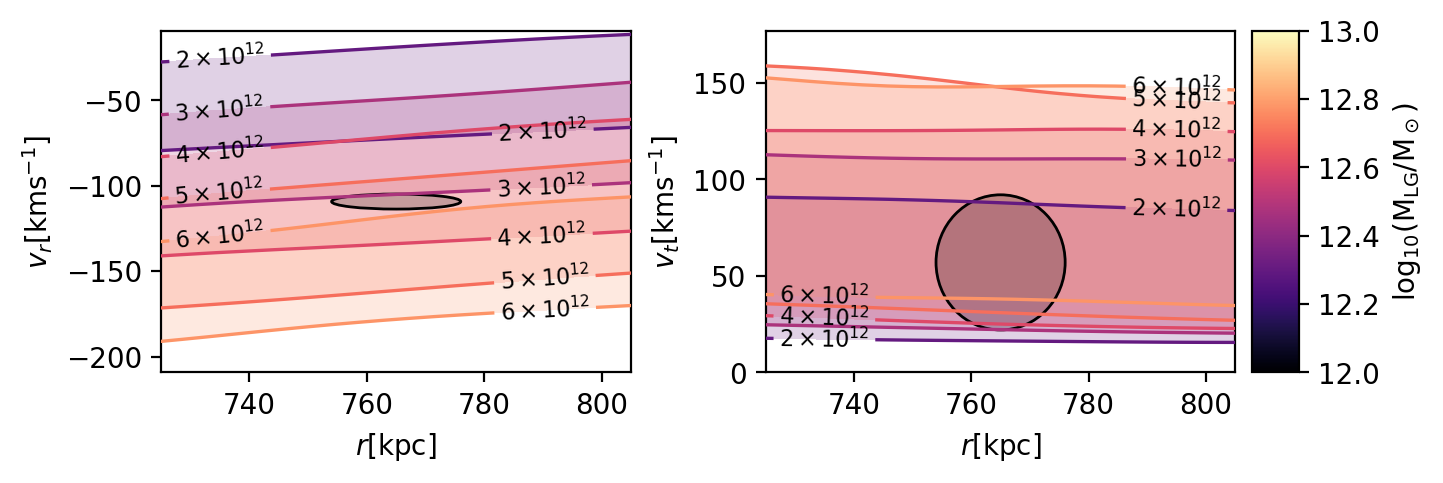

In [28]:
range_r = 40
range_vr = 100
range_vt = 120

fig, ax = plt.subplots(figsize=(DoubleColumn,2.3), ncols=3, nrows=1, dpi=dpi, gridspec_kw={'width_ratios': [10, 10, 1]}, constrained_layout = True)

ax[0].set_xlim(r_obs[0]-range_r,r_obs[0]+range_r)
ax[0].set_ylim(vr_obs[0]-range_vr,vr_obs[0]+range_vr)

ax[1].set_xlim(r_obs[0]-range_r,r_obs[0]+range_r)
ax[1].set_ylim(0,vt_obs[0]+range_vt)

origin = 'lower'
levels = [0.6065,1] # this corresponds to the height of a standard normal distribution at 1 sigma.

for mass_bin in range(5):

    # this is a bit clumsy, but the placing of the contour labels needs to be done manually.
    if mass_bin == 0:
        manual_locations_vr = [(735, -25), (790, -70)]
        manual_locations_vt = [(735, 20), (795, 90)]   
        mass_str=r'$2 \times 10^{12}$'
    
    if mass_bin == 1:
        manual_locations_vr = [(735, -60), (790, -120)]
        manual_locations_vt = [(795, 100)]  
        mass_str=r'$3 \times 10^{12}$'

    if mass_bin == 2:
        manual_locations_vr = [(735, -80), (790, -140)]
        manual_locations_vt = [(735, 30), (795, 125)]
        mass_str=r'$4 \times 10^{12}$'
        
    if mass_bin == 3:
        manual_locations_vr = [(735, -110), (790, -140)]
        manual_locations_vt = [(795, 140)]
        mass_str=r'$5 \times 10^{12}$'
        
    if mass_bin == 4:
        manual_locations_vr = [(735, -130), (790, -150)]
        manual_locations_vt = [(735, 35), (795, 150)]
        mass_str=r'$6 \times 10^{12}$'
        
    if mass_bin == 5:
        manual_locations_vr = [(735, -150), (790, -170)]
        manual_locations_vt = [(795, 40), (735, 130)]
        mass_str=r'$7 \times 10^{12}$'

        
    print ("mass_bin:", mass_bin)

    selection = list ( set(selection_true) & set(mass_subsets[mass_bin]) )
    selection_subset = selection[0:20000]

    fmt = {}
    strs = [mass_str, 'nothing']

    c = cmap( norm(np.mean(np.log10(LG_M_tot[selection]) )) )

    # r vs vr
    
    # Peform the kernel density estimate
    x = LG_r[selection_subset]
    y = LG_vr[selection_subset]

    k = gaussian_kde(np.vstack([x, y]), )

    xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

    #set zi to 0-1 scale
    zi = (zi-zi.min())/(zi.max() - zi.min())
    zi =zi.reshape(xi.shape)

    CS = ax[0].contour(xi, yi, zi,levels = levels, colors=(c,), linewidths=(1.2,), linestyles=('solid'), origin=origin, zorder =100)

    for l, s in zip(CS.levels, strs):
        fmt[l] = s

    ax[0].clabel(CS, CS.levels, fmt=fmt, fontsize=8, colors='black', manual=manual_locations_vr)

    CSf = ax[0].contourf(xi, yi, zi,levels = levels, colors=(c,), alpha=0.2, origin=origin)
    
    # r vs vt
    
    # Peform the kernel density estimate
    x = LG_r[selection_subset]
    y = LG_vt[selection_subset]

    k = gaussian_kde(np.vstack([x, y]), )

    xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

    #set zi to 0-1 scale
    zi = (zi-zi.min())/(zi.max() - zi.min())
    zi =zi.reshape(xi.shape)

    CS = ax[1].contour(xi, yi, zi,levels = levels, colors=(c,), linewidths=(1.2,), linestyles=('solid'), origin=origin, zorder =100)

    for l, s in zip(CS.levels, strs):
        fmt[l] = s
    
    ax[1].clabel(CS, CS.levels, fmt=fmt, fontsize=8, colors='black', manual=manual_locations_vt)
    
    CSf = ax[1].contourf(xi, yi, zi,levels = levels, colors=(c,), alpha=0.2, origin=origin)


# error ellipses
el = mpatches.Ellipse((r_obs[0], vr_obs[0] ), r_obs[1]*2, vr_obs[1]*2,  edgecolor=(0, 0, 0, 1), facecolor=(0, 0, 0, 0.2), lw=1)
ax[0].add_artist(el)
    
el = mpatches.Ellipse((r_obs[0], vt_obs[0] ), r_obs[1]*2, vt_obs[1]*2,  edgecolor=(0, 0, 0, 1), facecolor=(0, 0, 0, 0.2), lw=1)
ax[1].add_artist(el)

ax[0].set_ylabel(r'$v_r \left[\mathrm{kms^{-1}}\right]$')
ax[0].set_xlabel(r'$r \left[\mathrm{kpc}\right]$')
ax[1].set_ylabel(r'$v_t \left[\mathrm{kms^{-1}}\right]$')
ax[1].set_xlabel(r'$r \left[\mathrm{kpc}\right]$')

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax[2])
ax[2].set_ylabel(r'$\mathrm{log_{10}\left(M_{LG}/M_\odot\right)}$')

plt.savefig(plot_directory+'/uchuu_r_vr_vt_mass_conturs.pdf', bbox_inches='tight')